In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# define work directory to store data
DATA_ROOT = '/content/drive/MyDrive/ACMDD/DeNovo/data' # or wherever you want the generated files to live on your GoogleDrive
import os
os.makedirs(DATA_ROOT, exist_ok=True)
os.chdir(DATA_ROOT) 

In [3]:
# Get the structures
uniprot_id = "P18031" #PTP1B (2QBS)
TARGET_PDB_ID = "2qbs" # Enter your target PDB code here
LIGAND_CODE = "024" # Enter the ligand code here
OFF_TARGET_PDB_ID = "2qbq" # Enter your off target PDB code here
OFF_TARGET_LIGAND = "4B3"  # Enter the ligand code here

PDBCODE_1 = '2qbs' # Name of the first structure
PDBCODE_2 = '2qbq' # Name of the second structure

PDBCODE = '2qbs' # As in lab 1, change this to your PDB accession code.
LIGAND_CODE = '024' # and add the ligand code

In [4]:
#install
!pip install oddt
# And we need to install vina
!pip install vina
!pip install py3Dmol
!pip install MDAnalysis
!pip install nglview
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 34.3 MB/s 
     |████████████████████████████████| 52 kB 1.4 MB/s 
     |████████████████████████████████| 3.2 MB 50.9 MB/s 
     |████████████████████████████████| 90 kB 10.8 MB/s 
     |████████████████████████████████| 133 kB 73.1 MB/s 
     |████████████████████████████████| 121 kB 70.1 MB/s 
     |████████████████████████████████| 100 kB 12.2 MB/s 
     |████████████████████████████████| 1.1 MB 65.8 MB/s 
     |████████████████████████████████| 84 kB 4.0 MB/s 
  Created wheel for oddt: filename=oddt-0.7-py2.py3-none-any.whl size=2409559 sha256=b36beb8326a920a1578af1cf406b00c2d585c2dd492e48b1c13aff2a37a11572
  Stored in directory: /root/.cache/pip/wheels/d6/43/d5/d9cd8676d2d1bf10e0becb3f75d52b8ff354fdd691974524c0
Successfully built oddt
  Attempting uninstall: Pygments
    Found existing installation: Pygments 2.6.1
    Uninstalling Pygme

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.0 MB 16.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.5 MB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 2.1 MB 61.1 MB/s 
     |████████████████████████████████| 2.6 MB 72.5 MB/s 
     |████████████████████████████████| 376 kB 64.4 MB/s 
     |████████████████████████████████| 43 kB 2.8 MB/s 
  Created wheel for MDAnalysis: filename=MDAnalysis-2.1.0-cp37-cp37m-linux_x86_64.whl size=4649748 sha256=b73b92448a21375467c3e985e7cb26a399572054b4414755eb067f9b8ce51001
  Stored in directory: /root/.cache/pip/wheels/fa/dd/6b/9d51e

In [5]:
#import
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

In [6]:
%%capture
try:
    from rdkit.Chem import PandasTools
    from chembl_webresource_client.new_client import new_client
except:
    !pip install chembl_webresource_client
    !pip install rdkit

import math
from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory
from rdkit.Chem import PandasTools
from chembl_webresource_client.new_client import new_client
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

In [7]:
targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity

In [8]:
# Get target information from ChEMBL but restrict it to specified values only
targets = targets_api.get(target_components__accession=uniprot_id).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)
print(f'The type of the targets is "{type(targets)}"')

The type of the targets is "<class 'chembl_webresource_client.query_set.QuerySet'>"


In [9]:
# Select first entry
targets = pd.DataFrame.from_records(targets)
targets

,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,Protein-tyrosine phosphatase 1B,CHEMBL335,SINGLE PROTEIN
1,Homo sapiens,Protein-tyrosine phosphatase 1B,CHEMBL335,SINGLE PROTEIN


In [10]:
target = targets.iloc[0]
target

organism                               Homo sapiens
pref_name           Protein-tyrosine phosphatase 1B
target_chembl_id                          CHEMBL335
target_type                          SINGLE PROTEIN
Name: 0, dtype: object

In [11]:
chembl_id = target.target_chembl_id
print(f"The target ChEMBL ID is {chembl_id}")
# NBVAL_CHECK_OUTPUT

The target ChEMBL ID is CHEMBL335


In [12]:
bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id, type="IC50", relation="=", assay_type="B"
).only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
)

print(f"Length and type of bioactivities object: {len(bioactivities)}, {type(bioactivities)}")

Length and type of bioactivities object: 3437, <class 'chembl_webresource_client.query_set.QuerySet'>


In [13]:
print(f"Length and type of first element: {len(bioactivities[0])}, {type(bioactivities[0])}")
bioactivities[0]

Length and type of first element: 13, <class 'dict'>


{'activity_id': 33473,
 'assay_chembl_id': 'CHEMBL772435',
 'assay_description': 'In vitro inhibitory activity against recombinant human protein-tyrosine phosphatase 1B (PTP1B) using fluorescein diphosphate (FDP) as a substrate',
 'assay_type': 'B',
 'molecule_chembl_id': 'CHEMBL301254',
 'relation': '=',
 'standard_units': 'nM',
 'standard_value': '1540.0',
 'target_chembl_id': 'CHEMBL335',
 'target_organism': 'Homo sapiens',
 'type': 'IC50',
 'units': 'uM',
 'value': '1.54'}

In [14]:
bioactivities_df = pd.DataFrame.from_records(bioactivities)
print(f"DataFrame shape: {bioactivities_df.shape}")
bioactivities_df.head()

DataFrame shape: (3438, 13)


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,33473,CHEMBL772435,In vitro inhibitory activity against recombina...,B,CHEMBL301254,=,nM,1540.0,CHEMBL335,Homo sapiens,IC50,uM,1.54
1,33473,CHEMBL772435,In vitro inhibitory activity against recombina...,B,CHEMBL301254,=,nM,1540.0,CHEMBL335,Homo sapiens,IC50,uM,1.54
2,33479,CHEMBL772435,In vitro inhibitory activity against recombina...,B,CHEMBL58435,=,nM,10130.0,CHEMBL335,Homo sapiens,IC50,uM,10.13
3,34712,CHEMBL770122,Inhibition of human Protein-tyrosine phosphata...,B,CHEMBL57157,=,nM,610.0,CHEMBL335,Homo sapiens,IC50,uM,0.61
4,34713,CHEMBL770122,Inhibition of human Protein-tyrosine phosphata...,B,CHEMBL292444,=,nM,1010.0,CHEMBL335,Homo sapiens,IC50,uM,1.01


In [15]:
bioactivities_df["units"].unique()

array(['uM', 'nM', 'mM', 'ug ml-1', 'microM', 'umol/L', 'umol/ml',
       "10'-5M", "10'20 uM"], dtype=object)

In [16]:
# Remove irrelevant data
bioactivities_df.drop(["units", "value"], axis=1, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,33473,CHEMBL772435,In vitro inhibitory activity against recombina...,B,CHEMBL301254,=,nM,1540.0,CHEMBL335,Homo sapiens,IC50
1,33473,CHEMBL772435,In vitro inhibitory activity against recombina...,B,CHEMBL301254,=,nM,1540.0,CHEMBL335,Homo sapiens,IC50
2,33479,CHEMBL772435,In vitro inhibitory activity against recombina...,B,CHEMBL58435,=,nM,10130.0,CHEMBL335,Homo sapiens,IC50
3,34712,CHEMBL770122,Inhibition of human Protein-tyrosine phosphata...,B,CHEMBL57157,=,nM,610.0,CHEMBL335,Homo sapiens,IC50
4,34713,CHEMBL770122,Inhibition of human Protein-tyrosine phosphata...,B,CHEMBL292444,=,nM,1010.0,CHEMBL335,Homo sapiens,IC50


In [17]:
bioactivities_df.dtypes

activity_id            int64
assay_chembl_id       object
assay_description     object
assay_type            object
molecule_chembl_id    object
relation              object
standard_units        object
standard_value        object
target_chembl_id      object
target_organism       object
type                  object
dtype: object

In [18]:
# Change the type of the IC50 values to float values
bioactivities_df = bioactivities_df.astype({"standard_value": "float64"})
bioactivities_df.dtypes

activity_id             int64
assay_chembl_id        object
assay_description      object
assay_type             object
molecule_chembl_id     object
relation               object
standard_units         object
standard_value        float64
target_chembl_id       object
target_organism        object
type                   object
dtype: object

In [19]:
bioactivities_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (3438, 11)


In [20]:
# Only keep entries which are measured in nM
print(f"Units in downloaded data: {bioactivities_df['standard_units'].unique()}")
print(
    f"Number of non-nM entries:\
    {bioactivities_df[bioactivities_df['standard_units'] != 'nM'].shape[0]}"
)
bioactivities_df = bioactivities_df[bioactivities_df["standard_units"] == "nM"]
print(f"Units after filtering: {bioactivities_df['standard_units'].unique()}")
print(f"DataFrame shape: {bioactivities_df.shape}")

Units in downloaded data: ['nM' 'ug.mL-1' "10'20 uM"]
Number of non-nM entries:    68
Units after filtering: ['nM']
DataFrame shape: (3370, 11)


In [21]:
mean = bioactivities_df.groupby('molecule_chembl_id').mean().reset_index()
unique = bioactivities_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=False)
unique.sort_values('molecule_chembl_id', inplace=True)
unique['standard_value'] = mean['standard_value'].values

bioactivities_df = unique
bioactivities_df.head()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
92,439847,CHEMBL771320,Inhibitory activity against human Protein-tyro...,B,CHEMBL100267,=,nM,20000000.0,CHEMBL335,Homo sapiens,IC50
505,1264005,CHEMBL772439,Inhibitory concentration towards recombinant h...,B,CHEMBL101427,=,nM,19000.0,CHEMBL335,Homo sapiens,IC50
492,1228545,CHEMBL772439,Inhibitory concentration towards recombinant h...,B,CHEMBL102015,=,nM,24000.0,CHEMBL335,Homo sapiens,IC50
493,1229794,CHEMBL772439,Inhibitory concentration towards recombinant h...,B,CHEMBL103709,=,nM,25000.0,CHEMBL335,Homo sapiens,IC50
494,1234702,CHEMBL772439,Inhibitory concentration towards recombinant h...,B,CHEMBL103942,=,nM,30000.0,CHEMBL335,Homo sapiens,IC50


In [22]:
mean

,molecule_chembl_id,activity_id,standard_value
0,CHEMBL100267,439847.0,20000000.0
1,CHEMBL101427,1264005.0,19000.0
2,CHEMBL102015,1228545.0,24000.0
3,CHEMBL103709,1229794.0,25000.0
4,CHEMBL103942,1234702.0,30000.0
...,...,...,...
2984,CHEMBL99271,596568.5,54000.0
2985,CHEMBL99657,595199.0,24000.0
2986,CHEMBL99776,592733.0,24000.0
2987,CHEMBL99971,467482.0,12000000.0


In [23]:
bioactivities_df.reset_index(drop=True, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,439847,CHEMBL771320,Inhibitory activity against human Protein-tyro...,B,CHEMBL100267,=,nM,20000000.0,CHEMBL335,Homo sapiens,IC50
1,1264005,CHEMBL772439,Inhibitory concentration towards recombinant h...,B,CHEMBL101427,=,nM,19000.0,CHEMBL335,Homo sapiens,IC50
2,1228545,CHEMBL772439,Inhibitory concentration towards recombinant h...,B,CHEMBL102015,=,nM,24000.0,CHEMBL335,Homo sapiens,IC50
3,1229794,CHEMBL772439,Inhibitory concentration towards recombinant h...,B,CHEMBL103709,=,nM,25000.0,CHEMBL335,Homo sapiens,IC50
4,1234702,CHEMBL772439,Inhibitory concentration towards recombinant h...,B,CHEMBL103942,=,nM,30000.0,CHEMBL335,Homo sapiens,IC50


In [24]:
bioactivities_df.rename(
    columns={"standard_value": "IC50", "standard_units": "units"}, inplace=True
)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,units,IC50,target_chembl_id,target_organism,type
0,439847,CHEMBL771320,Inhibitory activity against human Protein-tyro...,B,CHEMBL100267,=,nM,20000000.0,CHEMBL335,Homo sapiens,IC50
1,1264005,CHEMBL772439,Inhibitory concentration towards recombinant h...,B,CHEMBL101427,=,nM,19000.0,CHEMBL335,Homo sapiens,IC50
2,1228545,CHEMBL772439,Inhibitory concentration towards recombinant h...,B,CHEMBL102015,=,nM,24000.0,CHEMBL335,Homo sapiens,IC50
3,1229794,CHEMBL772439,Inhibitory concentration towards recombinant h...,B,CHEMBL103709,=,nM,25000.0,CHEMBL335,Homo sapiens,IC50
4,1234702,CHEMBL772439,Inhibitory concentration towards recombinant h...,B,CHEMBL103942,=,nM,30000.0,CHEMBL335,Homo sapiens,IC50


In [25]:
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (2989, 11)


In [26]:
compounds_provider = compounds_api.filter(
    molecule_chembl_id__in=list(bioactivities_df["molecule_chembl_id"])
).only("molecule_chembl_id", "molecule_structures")

In [27]:
compounds = list(tqdm(compounds_provider))

  0%|          | 0/2989 [00:00<?, ?it/s]

In [28]:
compounds_df = pd.DataFrame.from_records(
    compounds,
)
print(f"DataFrame shape: {compounds_df.shape}")
compounds_df.head()

DataFrame shape: (2989, 2)


,molecule_chembl_id,molecule_structures
0,CHEMBL408,{'canonical_smiles': 'Cc1c(C)c2c(c(C)c1O)CCC(C...
1,CHEMBL6518,{'canonical_smiles': 'CCCCCCCC/C(=C/Cn1oc(=O)n...
2,CHEMBL203751,{'canonical_smiles': 'Cc1oc(-c2ccc(C(F)(F)F)cc...
3,CHEMBL6845,{'canonical_smiles': 'C/C(=C\Cn1oc(=O)[nH]c1=O...
4,CHEMBL265665,{'canonical_smiles': 'CCCCCCCC/C(=C\Cn1oc(=O)n...


In [29]:
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (2983, 2)


In [30]:
compounds_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (2983, 2)


In [31]:
compounds_df.iloc[0].molecule_structures.keys()

dict_keys(['canonical_smiles', 'molfile', 'standard_inchi', 'standard_inchi_key'])

In [32]:
# Rows not having a canonical smiles structure will be removed
canonical_smiles = []

for i, compounds in compounds_df.iterrows():
    try:
        canonical_smiles.append(compounds["molecule_structures"]["canonical_smiles"])
    except KeyError:
        canonical_smiles.append(None)

compounds_df["smiles"] = canonical_smiles
compounds_df.drop("molecule_structures", axis=1, inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (2983, 2)


In [33]:
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (2983, 2)


In [34]:
print(f"Bioactivities filtered: {bioactivities_df.shape[0]}")
print(f"Compounds filtered: {compounds_df.shape[0]}")

Bioactivities filtered: 2989
Compounds filtered: 2983


In [35]:
# Merge DataFrames
output_df = pd.merge(
    bioactivities_df[["molecule_chembl_id", "IC50", "units"]],
    compounds_df,
    on="molecule_chembl_id",
)

# Reset row indices
output_df.reset_index(drop=True, inplace=True)

print(f"Dataset with {output_df.shape[0]} entries.")

Dataset with 2983 entries.


In [36]:
output_df.dtypes
output_df.head(10)

,molecule_chembl_id,IC50,units,smiles
0,CHEMBL100267,20000000.0,nM,COc1ccc2cc(C(=O)O)ccc2c1C(=O)O
1,CHEMBL101427,19000.0,nM,C[C@H]1CCC[C@@H](C)N1NC(=O)c1ccc(Cl)c(S(=O)(=O...
2,CHEMBL102015,24000.0,nM,O=C(NS(=O)(=O)Cc1ccccc1)c1ccc2cc(C(F)(F)P(=O)(...
3,CHEMBL103709,25000.0,nM,O=C(NS(=O)(=O)c1cc(C2(O)NC(=O)c3ccccc32)ccc1Cl...
4,CHEMBL103942,30000.0,nM,O=C(NS(=O)(=O)c1ccccc1)c1ccc2cc(C(F)(F)P(=O)(O...
5,CHEMBL105872,45000.0,nM,O=S(=O)(/C=C/c1ccc2ccccc2c1)Nc1nc(-c2ccccc2)c(...
6,CHEMBL105999,29000.0,nM,CCCc1sc(NS(=O)(=O)/C=C/c2ccc(F)c(F)c2)nc1-c1cc...
7,CHEMBL106194,58000.0,nM,N#Cc1ccc(/C=C/S(=O)(=O)Nc2nc(-c3ccccc3)c(-c3cc...
8,CHEMBL106479,85000.0,nM,O=S(=O)(/C=C/c1ccc(F)c(F)c1)Nc1nc(-c2ccccc2)c(...
9,CHEMBL1076247,65500.0,nM,CCOCC1(CN2CCN(C)CC2)COc2ccc3c(C)cc(=O)oc3c2C1=O


In [37]:
# For a less crowded distribution, the values will be converted to pIC50
def convert_ic50_to_pic50(IC50_value):
    pIC50_value = 9 - math.log10(IC50_value)
    return pIC50_value

In [38]:
# Apply conversion to each row of the compounds DataFrame
output_df["pIC50"] = output_df.apply(lambda x: convert_ic50_to_pic50(x.IC50), axis=1)
output_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL100267,20000000.0,nM,COc1ccc2cc(C(=O)O)ccc2c1C(=O)O,1.698970
1,CHEMBL101427,19000.0,nM,C[C@H]1CCC[C@@H](C)N1NC(=O)c1ccc(Cl)c(S(=O)(=O...,4.721246
2,CHEMBL102015,24000.0,nM,O=C(NS(=O)(=O)Cc1ccccc1)c1ccc2cc(C(F)(F)P(=O)(...,4.619789
3,CHEMBL103709,25000.0,nM,O=C(NS(=O)(=O)c1cc(C2(O)NC(=O)c3ccccc32)ccc1Cl...,4.602060
4,CHEMBL103942,30000.0,nM,O=C(NS(=O)(=O)c1ccccc1)c1ccc2cc(C(F)(F)P(=O)(O...,4.522879


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb26aee32d0>]],
      dtype=object)

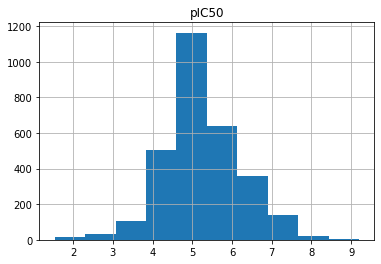

In [39]:
output_df.hist(column="pIC50")

In [40]:
#save image
plt.savefig("Images/Histogram_pIC50.png")

<Figure size 432x288 with 0 Axes>

In [41]:
# Add molecule column
PandasTools.AddMoleculeColumnToFrame(output_df, smilesCol="smiles")

In [42]:
# Sort molecules by pIC50
output_df.sort_values(by="pIC50", ascending=False, inplace=True)

# Reset index
output_df.reset_index(drop=True, inplace=True)

In [43]:
output_df.drop("smiles", axis=1)
output_df.head(4)

,molecule_chembl_id,IC50,units,smiles,pIC50,ROMol
0,CHEMBL444092,0.635000,nM,C=C1C(=O)N[C@H](C)C(=O)N[C@@H](CC(C)C)C(=O)N[C...,9.197226,<rdkit.Chem.rdchem.Mol object at 0x7fb26a9e5b70>
1,CHEMBL430266,0.666667,nM,COC[C@@H]([C@H](O)[C@H](O)C(=O)NCC[C@H](C)c1nc...,9.176091,<rdkit.Chem.rdchem.Mol object at 0x7fb26a9e4bc0>
2,CHEMBL505512,0.670000,nM,CO[C@H]([C@H](O)CC(=O)[C@@H](C)[C@@H](O)CC[C@@...,9.173925,<rdkit.Chem.rdchem.Mol object at 0x7fb26a9706c0>
3,CHEMBL509059,1.490000,nM,COC[C@@H]([C@H](O)[C@H](O)C(=O)N[C@H](C)C[C@H]...,8.826814,<rdkit.Chem.rdchem.Mol object at 0x7fb26a970c10>


In [44]:
# Prepare saving the dataset: Drop the ROMol column
output_df = output_df.drop("ROMol", axis=1)
print(f"DataFrame shape: {output_df.shape}")

DataFrame shape: (2983, 5)


In [45]:
# Save dataset for next notebook
output_df.to_csv('PTP1B_compounds.csv')
output_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL444092,0.635000,nM,C=C1C(=O)N[C@H](C)C(=O)N[C@@H](CC(C)C)C(=O)N[C...,9.197226
1,CHEMBL430266,0.666667,nM,COC[C@@H]([C@H](O)[C@H](O)C(=O)NCC[C@H](C)c1nc...,9.176091
2,CHEMBL505512,0.670000,nM,CO[C@H]([C@H](O)CC(=O)[C@@H](C)[C@@H](O)CC[C@@...,9.173925
3,CHEMBL509059,1.490000,nM,COC[C@@H]([C@H](O)[C@H](O)C(=O)N[C@H](C)C[C@H]...,8.826814
4,CHEMBL4524071,1.710000,nM,C/C=C1\C(=O)N[C@@H](C(=O)O)[C@H](C)C(=O)N[C@@H...,8.767004


,Unnamed: 0,molecule_chembl_id,IC50,units,smiles,pIC50,ROMol
0,0,CHEMBL444092,6.350000e-01,nM,C=C1C(=O)N[C@H](C)C(=O)N[C@@H](CC(C)C)C(=O)N[C...,9.197226,
1,1,CHEMBL430266,6.666667e-01,nM,COC[C@@H]([C@H](O)[C@H](O)C(=O)NCC[C@H](C)c1nc...,9.176091,
2,2,CHEMBL505512,6.700000e-01,nM,CO[C@H]([C@H](O)CC(=O)[C@@H](C)[C@@H](O)CC[C@@...,9.173925,
3,3,CHEMBL509059,1.490000e+00,nM,COC[C@@H]([C@H](O)[C@H](O)C(=O)N[C@H](C)C[C@H]...,8.826814,
4,4,CHEMBL4524071,1.710000e+00,nM,C/C=C1\C(=O)N[C@@H](C(=O)O)[C@H](C)C(=O)N[C@@H...,8.767004,
...,...,...,...,...,...,...,...
2978,2978,CHEMBL324473,1.220000e+07,nM,C=CCOC(=O)/C=C\c1cccc(C(F)(F)P(=O)(O)O)c1.N.N,1.913640,
2979,2979,CHEMBL169826,1.300000e+07,nM,CC(=O)N[C@@H](CC(=O)O)C(=O)N[C@@H](C)C(=O)N[C@...,1.886057,
2980,2980,CHEMBL100267,2.000000e+07,nM,COc1ccc2cc(C(=O)O)ccc2c1C(=O)O,1.698970,
2981,2981,CHEMBL95668,2.800000e+07,nM,O=S(=O)([O-])c1cccc2c(S(=O)(=O)[O-])cccc12.[Na...,1.552842,

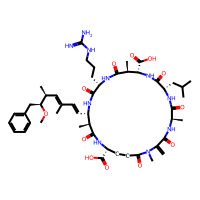
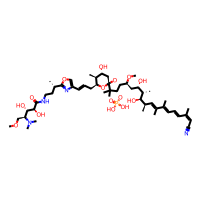
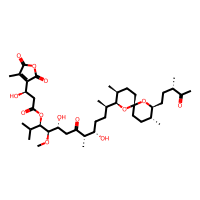
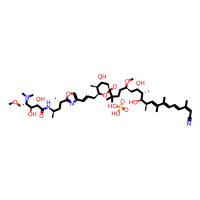
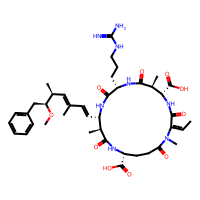
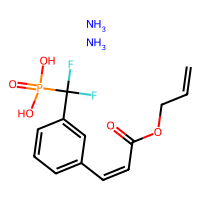
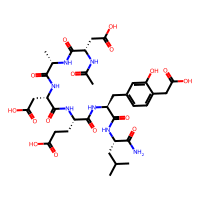
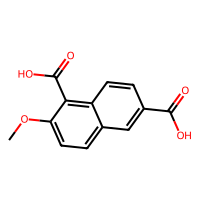
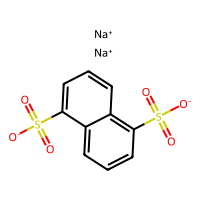
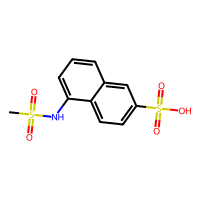

In [46]:
# Load Data
molecules = pd.read_csv('PTP1B_compounds.csv')
PandasTools.AddMoleculeColumnToFrame(molecules, "smiles")
molecules

In [47]:
try:
    from rdkit import Chem
    from rdkit.Chem import Descriptors, Draw, PandasTools
except:
    !pip install rdkit

from pathlib import Path
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, PandasTools

,Unnamed: 0,molecule_chembl_id,IC50,units,smiles,pIC50,ROMol,molecular_weight,n_hba,n_hbd,logp
0,0,CHEMBL444092,6.350000e-01,nM,C=C1C(=O)N[C@H](C)C(=O)N[C@@H](CC(C)C)C(=O)N[C...,9.197226,,994.548768,11,11,0.82807
1,1,CHEMBL430266,6.666667e-01,nM,COC[C@@H]([C@H](O)[C@H](O)C(=O)NCC[C@H](C)c1nc...,9.176091,,1008.543605,16,8,4.68898
2,2,CHEMBL505512,6.700000e-01,nM,CO[C@H]([C@H](O)CC(=O)[C@@H](C)[C@@H](O)CC[C@@...,9.173925,,766.450342,13,3,4.78530
3,3,CHEMBL509059,1.490000e+00,nM,COC[C@@H]([C@H](O)[C@H](O)C(=O)N[C@H](C)C[C@H]...,8.826814,,1022.559255,16,8,5.07748
4,4,CHEMBL4524071,1.710000e+00,nM,C/C=C1\C(=O)N[C@@H](C(=O)O)[C@H](C)C(=O)N[C@@H...,8.767004,,824.443240,9,9,1.18257
...,...,...,...,...,...,...,...,...,...,...,...
2978,2978,CHEMBL324473,1.220000e+07,nM,C=CCOC(=O)/C=C\c1cccc(C(F)(F)P(=O)(O)O)c1.N.N,1.913640,,352.099965,5,4,2.98000
2979,2979,CHEMBL169826,1.300000e+07,nM,CC(=O)N[C@@H](CC(=O)O)C(=O)N[C@@H](C)C(=O)N[C@...,1.886057,,823.323578,12,12,-3.14400
2980,2980,CHEMBL100267,2.000000e+07,nM,COc1ccc2cc(C(=O)O)ccc2c1C(=O)O,1.698970,,246.052823,3,2,2.24480
2981,2981,CHEMBL95668,2.800000e+07,nM,O=S(=O)([O-])c1cccc2c(S(=O)(=O)[O-])cccc12.[Na...,1.552842,,331.940118,6,0,-5.34400

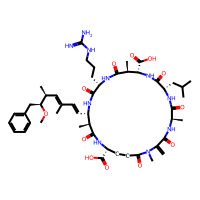
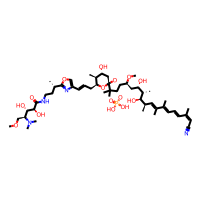
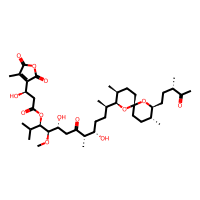
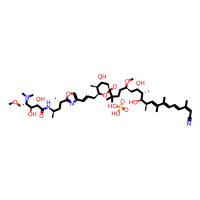
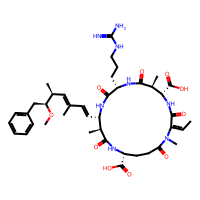
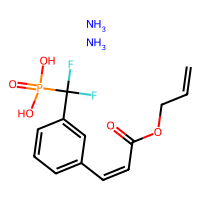
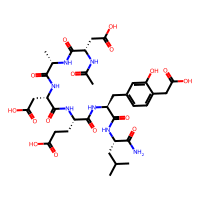
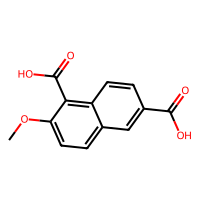
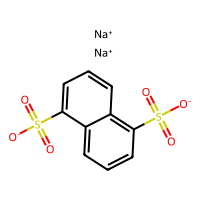
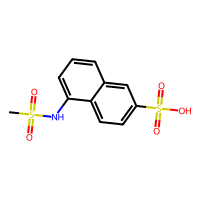

In [48]:
# Clipping molecular properties to the dataframe, properties of the Lipinski-rule
molecules["molecular_weight"] = molecules["ROMol"].apply(Descriptors.ExactMolWt)
molecules["n_hba"] = molecules["ROMol"].apply(Descriptors.NumHAcceptors)
molecules["n_hbd"] = molecules["ROMol"].apply(Descriptors.NumHDonors)
molecules["logp"] = molecules["ROMol"].apply(Descriptors.MolLogP)
# Colors are used for plotting the molecules later
# NBVAL_CHECK_OUTPUT
molecules

In [49]:
# Define the Lipinski rule
ro5_properties = {
    "molecular_weight": (500, "molecular weight (Da)"),
    "n_hba": (10, "# HBA"),
    "n_hbd": (5, "# HBD"),
    "logp": (5, "logP"),
}

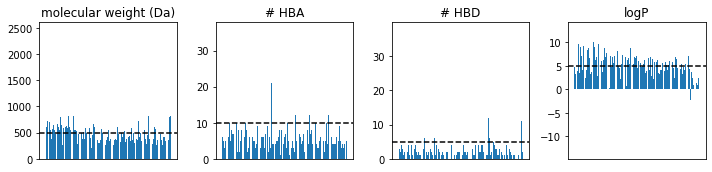

In [50]:
# Start 1x4 plot frame
fig, axes = plt.subplots(figsize=(10, 2.5), nrows=1, ncols=4)
x = np.arange(1, len(molecules) + 1)

# Create subplots
for index, (key, (threshold, title)) in enumerate(ro5_properties.items()):
    axes[index].bar(molecules['molecule_chembl_id'],molecules[key])
    axes[index].axhline(y=threshold, color="black", linestyle="dashed")
    axes[index].set_title(title)
    axes[index].set_xticks([])

# Fit subplots and legend into figure
plt.tight_layout()
plt.show()

In [51]:
#save image
plt.savefig("Images/Lipinski's rule plot")

<Figure size 432x288 with 0 Axes>

In [52]:
def calculate_ro5_properties(smiles):
    """
    Test if input molecule (SMILES) fulfills Lipinski's rule of five.

    Parameters
    ----------
    smiles : str
        SMILES for a molecule.

    Returns
    -------
    pandas.Series
        Molecular weight, number of hydrogen bond acceptors/donor and logP value
        and Lipinski's rule of five compliance for input molecule.
    """
    # RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(smiles)
    # Calculate Ro5-relevant chemical properties
    molecular_weight = Descriptors.ExactMolWt(molecule)
    n_hba = Descriptors.NumHAcceptors(molecule)
    n_hbd = Descriptors.NumHDonors(molecule)
    logp = Descriptors.MolLogP(molecule)
    # Check if Ro5 conditions fulfilled
    conditions = [molecular_weight <= 500, n_hba <= 10, n_hbd <= 5, logp <= 5]
    ro5_fulfilled = sum(conditions) >= 3
    # Return True if no more than one out of four conditions is violated
    return pd.Series(
        [molecular_weight, n_hba, n_hbd, logp, ro5_fulfilled],
        index=["molecular_weight", "n_hba", "n_hbd", "logp", "ro5_fulfilled"],
    )

In [53]:
# This takes a couple of seconds
ro5_properties = molecules["smiles"].apply(calculate_ro5_properties)
molecules = pd.concat([molecules, ro5_properties], axis=1)
molecules = molecules[molecules['ro5_fulfilled']]
molecules

,Unnamed: 0,molecule_chembl_id,IC50,units,smiles,pIC50,ROMol,molecular_weight,n_hba,n_hbd,logp,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
10,10,CHEMBL411295,7.0,nM,O=C(O)c1cccc(/C=C/c2ccc3cc(Br)c(C(F)(F)P(=O)(O...,8.154902,<rdkit.Chem.rdchem.Mol object at 0x7fb26a9a5bc0>,482.968278,3,3,5.0929,482.968278,3,3,5.0929,True
13,13,CHEMBL377141,10.0,nM,O=C1CC(c2ccc(C[C@H](NS(=O)(=O)c3cccc(C(F)(F)F)...,8.000000,<rdkit.Chem.rdchem.Mol object at 0x7fb26a9a54e0>,652.024097,6,2,2.3154,652.024097,6,2,2.3154,True
15,15,CHEMBL1938829,11.0,nM,O=C(O)COc1ccc(S(=O)(=O)N(Cc2ccc(-c3csnn3)cc2)C...,7.958607,<rdkit.Chem.rdchem.Mol object at 0x7fb26a9a5ad0>,694.056877,9,3,4.9739,694.056877,9,3,4.9739,True
16,16,CHEMBL604457,12.6,nM,CS(=O)(=O)OC1C(Cl)CCCC1Cc1ccc(N2CC(=O)CS2(=O)=...,7.899629,<rdkit.Chem.rdchem.Mol object at 0x7fb26afef620>,451.052622,7,1,1.4059,451.052622,7,1,1.4059,True
17,17,CHEMBL592290,14.0,nM,O=C1CN(c2c(O)cc(CC3CCCCC3)cc2F)S(=O)(=O)C1,7.853872,<rdkit.Chem.rdchem.Mol object at 0x7fb26a9aca30>,341.109707,4,1,2.3730,341.109707,4,1,2.3730,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2977,2977,CHEMBL99971,12000000.0,nM,O=C(O)c1ccc2c(C(=O)O)c(O)ccc2c1,1.920819,<rdkit.Chem.rdchem.Mol object at 0x7fb26a8d6bc0>,232.037173,3,3,1.9418,232.037173,3,3,1.9418,True
2978,2978,CHEMBL324473,12200000.0,nM,C=CCOC(=O)/C=C\c1cccc(C(F)(F)P(=O)(O)O)c1.N.N,1.913640,<rdkit.Chem.rdchem.Mol object at 0x7fb26a8d6c10>,352.099965,5,4,2.9800,352.099965,5,4,2.9800,True
2980,2980,CHEMBL100267,20000000.0,nM,COc1ccc2cc(C(=O)O)ccc2c1C(=O)O,1.698970,<rdkit.Chem.rdchem.Mol object at 0x7fb26a8d6cb0>,246.052823,3,2,2.2448,246.052823,3,2,2.2448,True
2981,2981,CHEMBL95668,28000000.0,nM,O=S(=O)([O-])c1cccc2c(S(=O)(=O)[O-])cccc12.[Na...,1.552842,<rdkit.Chem.rdchem.Mol object at 0x7fb26a8d6d00>,331.940118,6,0,-5.3440,331.940118,6,0,-5.3440,True


In [54]:
molecules.drop('ROMol', axis=1, inplace=True)
molecules.to_csv('PTP1B_compounds_lipinski.csv')

In [55]:
data = pd.read_csv('PTP1B_compounds_lipinski.csv')

#inactive & active classification
data['active'] = (data['pIC50']>7)
data

,Unnamed: 0,Unnamed: 0.1,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,molecular_weight.1,n_hba.1,n_hbd.1,logp.1,ro5_fulfilled,active
0,10,10,CHEMBL411295,7.0,nM,O=C(O)c1cccc(/C=C/c2ccc3cc(Br)c(C(F)(F)P(=O)(O...,8.154902,482.968278,3,3,5.0929,482.968278,3,3,5.0929,True,True
1,13,13,CHEMBL377141,10.0,nM,O=C1CC(c2ccc(C[C@H](NS(=O)(=O)c3cccc(C(F)(F)F)...,8.000000,652.024097,6,2,2.3154,652.024097,6,2,2.3154,True,True
2,15,15,CHEMBL1938829,11.0,nM,O=C(O)COc1ccc(S(=O)(=O)N(Cc2ccc(-c3csnn3)cc2)C...,7.958607,694.056877,9,3,4.9739,694.056877,9,3,4.9739,True,True
3,16,16,CHEMBL604457,12.6,nM,CS(=O)(=O)OC1C(Cl)CCCC1Cc1ccc(N2CC(=O)CS2(=O)=...,7.899629,451.052622,7,1,1.4059,451.052622,7,1,1.4059,True,True
4,17,17,CHEMBL592290,14.0,nM,O=C1CN(c2c(O)cc(CC3CCCCC3)cc2F)S(=O)(=O)C1,7.853872,341.109707,4,1,2.3730,341.109707,4,1,2.3730,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1987,2977,2977,CHEMBL99971,12000000.0,nM,O=C(O)c1ccc2c(C(=O)O)c(O)ccc2c1,1.920819,232.037173,3,3,1.9418,232.037173,3,3,1.9418,True,False
1988,2978,2978,CHEMBL324473,12200000.0,nM,C=CCOC(=O)/C=C\c1cccc(C(F)(F)P(=O)(O)O)c1.N.N,1.913640,352.099965,5,4,2.9800,352.099965,5,4,2.9800,True,False
1989,2980,2980,CHEMBL100267,20000000.0,nM,COc1ccc2cc(C(=O)O)ccc2c1C(=O)O,1.698970,246.052823,3,2,2.2448,246.052823,3,2,2.2448,True,False
1990,2981,2981,CHEMBL95668,28000000.0,nM,O=S(=O)([O-])c1cccc2c(S(=O)(=O)[O-])cccc12.[Na...,1.552842,331.940118,6,0,-5.3440,331.940118,6,0,-5.3440,True,False


In [56]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    # convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        return np.array(GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))
    if method == "morgan3":
        return np.array(GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [57]:
from pathlib import Path
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
import pandas as pd
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [58]:
X_train, X_test, y_train, y_test = train_test_split(data['smiles'].values, data['active'].values, test_size=0.3)

In [59]:
fp_X_train = []
for i in range(len(X_train)):
    fp_X_train.append(smiles_to_fp(X_train[i]))

In [60]:
fp_X_test = []
for i in range(len(X_test)):
    fp_X_test.append(smiles_to_fp(X_test[i]))

In [61]:
fp_X_train = np.array(fp_X_train)
fp_X_test = np.array(fp_X_test)
fp_X_train.shape
y_test.shape

(598,)

In [62]:
#Build model
inputLayer = Input(167,)
Hidden = Dense(32)(inputLayer)
Hidden = Dense(32, activation='relu')(Hidden)
Output = Dense(1, activation='sigmoid')(Hidden)

In [63]:
Model = tf.keras.Model(inputs=inputLayer, outputs=Output)
Model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 167)]             0         
                                                                 
 dense (Dense)               (None, 32)                5376      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6,465
Trainable params: 6,465
Non-trainable params: 0
_________________________________________________________________


In [64]:
Model.compile(optimizer="Adam", loss="binary_crossentropy", metrics=['accuracy'])
History = Model.fit(fp_X_train, y_train, validation_split=0.3, epochs=100)

Epoch 1/100
31/31 [==============================] - 3s 10ms/step - loss: 0.2586 - accuracy: 0.9395 - val_loss: 0.1689 - val_accuracy: 0.9642
Epoch 2/100
31/31 [==============================] - 0s 4ms/step - loss: 0.1521 - accuracy: 0.9631 - val_loss: 0.1280 - val_accuracy: 0.9642
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 0.1212 - accuracy: 0.9641 - val_loss: 0.1137 - val_accuracy: 0.9642
Epoch 4/100
31/31 [==============================] - 0s 4ms/step - loss: 0.1091 - accuracy: 0.9662 - val_loss: 0.1121 - val_accuracy: 0.9523
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 0.1061 - accuracy: 0.9672 - val_loss: 0.1047 - val_accuracy: 0.9547
Epoch 6/100
31/31 [==============================] - 0s 4ms/step - loss: 0.0976 - accuracy: 0.9621 - val_loss: 0.1219 - val_accuracy: 0.9642
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0956 - accuracy: 0.9631 - val_loss: 0.1021 - val_accuracy: 0.9642
Epoch 8/100


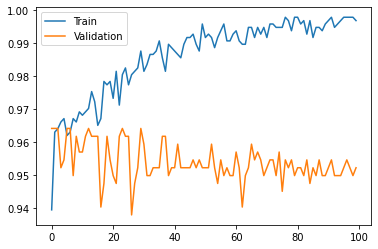

In [65]:
plt.plot(History.history['accuracy'], label='Train')
plt.plot(History.history['val_accuracy'], label='Validation')
plt.legend()
plt.show()

In [66]:
#save image
plt.savefig("Images/Train_Validation.png")

<Figure size 432x288 with 0 Axes>

In [67]:
evaluate = []
for i in range(len(data)):
    evaluate.append(smiles_to_fp(data['smiles'][i]))

evaluate = np.array(evaluate)
Model.evaluate(evaluate,data['active'].values)
    
Preds = Model(evaluate).numpy().round()
print("Predicted amount of active comps:",Model(evaluate).numpy().round().sum())
print("Actual amount of active comps:", data['active'].values.sum())
Preds = Preds.astype(bool)
Pos = data[Preds]
Neg = data[~Preds]

63/63 [==============================] - 0s 2ms/step - loss: 0.1103 - accuracy: 0.9759
Predicted amount of active comps: 77.0
Actual amount of active comps: 69


In [68]:
print("True Positives: ", Pos['active'].sum())
print("False Positives: ", len(Pos)-Pos['active'].sum())
print("True Negatives: ", len(Neg)-Neg['active'].sum())
print("False Negatives: ", Neg['active'].sum())


True Positives:  49
False Positives:  28
True Negatives:  1895
False Negatives:  20


In [69]:
#save Matrix
f = open('Matrix.txt','a')
print("True Positives: ", Pos['active'].sum(),file = f)
print("False Positives: ", len(Pos)-Pos['active'].sum(),file = f)
print("True Negatives: ", len(Neg)-Neg['active'].sum(),file = f)
print("False Negatives: ", Neg['active'].sum(),file = f)


In [70]:
Model.save('Activity_prediction.h5')

In [71]:
# fetch pretrained model
os.makedirs("drugex/models/pretrained/", exist_ok=True)
! wget -nc -P 'drugex/models/pretrained/' 'https://zenodo.org/record/7096859/files/DrugEx_v2_PT_Papyrus05.5.zip'
! unzip -n 'drugex/models/pretrained/DrugEx_v2_PT_Papyrus05.5.zip' -d './data/drugex/models/pretrained/DrugEx_v2_PT_Papyrus05.5'

# install dependencies
! git clone https://github.com/martin-sicho/drugex-demo
! pip install -r drugex-demo/requirements.txt

# verify where we are working
os.getcwd()

File ‘drugex/models/pretrained/DrugEx_v2_PT_Papyrus05.5.zip’ already there; not retrieving.

Archive:  drugex/models/pretrained/DrugEx_v2_PT_Papyrus05.5.zip
checkdir:  cannot create extraction directory: ./data/drugex/models/pretrained/DrugEx_v2_PT_Papyrus05.5
           No such file or directory
fatal: destination path 'drugex-demo' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/martin-sicho/DrugEx-CDDG.git (to revision master) to /tmp/pip-install-p7z0l4u_/drugex_4e534f9ed937409e86a6c0b6beb02c47
  Running command git clone -q https://github.com/martin-sicho/DrugEx-CDDG.git /tmp/pip-install-p7z0l4u_/drugex_4e534f9ed937409e86a6c0b6beb02c47
  Cloning https://github.com/martin-sicho/papyrus-scaffold-visualizer.git (to revision v0.2.0) to /tmp/pip-install-p7z0l4u_/papyrus-scaffold-visualizer_2d59624aa69e4d46962951feac0ffdb4
  Running command git clone -q https://gi

'/content/drive/MyDrive/ACMDD/DeNovo/data'

In [72]:
acc_keys = ["P18031"] # Adenosine receptor PTP1B (https://www.uniprot.org/uniprotkb/P29274/entry)
name = "PTP1B_LIGANDS" # name of the file to be generated
quality = "medium" # choose minimum quality from {"high", "medium", "low"}

In [118]:
from scaffviz.data.papyrus import Papyrus
 
# fetches latest version of Papyrus if not already available and filters out A2A data for us
papyrus = Papyrus(
    data_dir="./data", # data storage directory 
    stereo=False, # do not include stereochemistry
    version='latest'
)

In [119]:
dataset = papyrus.getData(
    acc_keys,
    quality,
    name,
    use_existing=True # use existing data set if it was already compiled before to speed things up
)

Latest version: 05.5
Number of files to be donwloaded: 6
Total size: 118MB


Donwloading version 05.5:   0%|          | 0.00/118M [00:00<?, ?B/s]

Using existing data from ./data/PTP1B_LIGANDS.tsv...


In [120]:
dataset.path

'./data/PTP1B_LIGANDS.tsv'

In [121]:
dataset.asDataFrame().head()

,Activity_ID,Quality,source,CID,SMILES,connectivity,InChIKey,InChI,InChI_AuxInfo,target_id,...,type_Ki,relation,pchembl_value,pchembl_value_Mean,pchembl_value_StdDev,pchembl_value_SEM,pchembl_value_N,pchembl_value_Median,pchembl_value_MAD,RDMol
0,AADVGRCQGZZZNH_on_P18031_WT,High,ChEMBL30,CHEMBL363338;44397840;CHEMBL363338;44397840;CH...,CC(C)CC(CC(=O)C(Cc1ccc(OC(F)(F)C(=O)O)cc1)NC(=...,AADVGRCQGZZZNH,AADVGRCQGZZZNH-UHFFFAOYSA-N,InChI=1S/C45H47F2N3O10/c1-27(2)22-30(41(48)53)...,"""AuxInfo=1/1/N:1,3,37,36,38,49,56,48,55,35,39,...",P18031_WT,...,0;0;0;0;1;1;0;0,=,5.42;5.42;5.42;5.42;5.42;5.42;5.42;5.42,5.42,0.0,0.0,8.0,5.42,0.0,<rdkit.Chem.rdchem.Mol object at 0x7fb0d3b0e620>
1,AAGZFGSRAZMRCS_on_P18031_WT,High,ChEMBL30,CHEMBL511000;CHEMBL511000;44563281;CHEMBL51100...,CC1(C)CCC2(C(=O)Nc3ccc(C(=O)O)cc3)CCC3(C)C(=CC...,AAGZFGSRAZMRCS,AAGZFGSRAZMRCS-UHFFFAOYSA-N,InChI=1S/C37H53NO4/c1-32(2)18-20-37(31(42)38-2...,"""AuxInfo=1/1/N:1,3,34,35,28,22,40,12,17,11,18,...",P18031_WT,...,0;0;0;0;0;0;1;1;1;0;0;0,=,5.51;5.51;5.51;5.51;5.51;5.51;5.51;5.51;5.51;5...,5.51,0.0,0.0,12.0,5.51,0.0,<rdkit.Chem.rdchem.Mol object at 0x7fb0ecfff7b0>
2,AATACZKOPAGNPL_on_P18031_WT,High,ChEMBL30,CHEMBL4160013,CCOc1ccc(OC(=O)CSc2nnc(-c3cc(O)c(O)cc3)o2)cc1,AATACZKOPAGNPL,AATACZKOPAGNPL-UHFFFAOYSA-N,InChI=1S/C18H16N2O6S/c1-2-24-12-4-6-13(7-5-12)...,"""AuxInfo=1/0/N:1,2,24,5,27,6,26,23,18,11,17,4,...",P18031_WT,...,1;0,=,5.1;5.1,5.10,0.0,0.0,2.0,5.10,0.0,<rdkit.Chem.rdchem.Mol object at 0x7fb0edfe4ad0>
3,AAWBMDOJDQKGGQ_on_P18031_WT,High,ChEMBL30,CHEMBL3759405,CCCOc1ccc(-c2cccc(-c3noc(Cc4c[nH]c5ccccc45)n3)...,AAWBMDOJDQKGGQ,AAWBMDOJDQKGGQ-UHFFFAOYSA-N,InChI=1S/C25H22N4O2/c1-2-14-30-19-12-10-17(11-...,"""AuxInfo=1/0/N:1,2,25,24,11,26,23,10,12,7,30,6...",P18031_WT,...,1;0,=,5.01;5.01,5.01,0.0,0.0,2.0,5.01,0.0,<rdkit.Chem.rdchem.Mol object at 0x7fb0d7387670>
4,ABDQNRCWGSGNBQ_on_P18031_WT,High,ChEMBL30,CHEMBL197929,O=C(O)COc1ccc(S(=O)(=O)N(Cc2ccc(C(F)(F)P(=O)(O...,ABDQNRCWGSGNBQ,ABDQNRCWGSGNBQ-UHFFFAOYSA-N,"InChI=1S/C21H20F2NO8PS2/c22-21(23,33(27,28)29)...","""AuxInfo=1/1/N:31,30,16,27,17,26,7,35,8,34,32,...",P18031_WT,...,1;0,=,6.0;6.0,6.00,0.0,0.0,2.0,6.00,0.0,<rdkit.Chem.rdchem.Mol object at 0x7fb0d6939c60>


In [122]:
type(dataset)

scaffviz.data.dataset.DataSetTSV

In [123]:
from scaffviz.clustering.descriptors import MorganFP

# add Morgan fingerprints to the data set -> will be used to calculate the t-SNE embedding for chemical space visualization
dataset.addDescriptors([MorganFP(radius=2, nBits=1024)], recalculate=False) 
dataset.getDescriptors()

,Descriptor_MorganFP_0,Descriptor_MorganFP_1,Descriptor_MorganFP_2,Descriptor_MorganFP_3,Descriptor_MorganFP_4,Descriptor_MorganFP_5,Descriptor_MorganFP_6,Descriptor_MorganFP_7,Descriptor_MorganFP_8,Descriptor_MorganFP_9,...,Descriptor_MorganFP_1014,Descriptor_MorganFP_1015,Descriptor_MorganFP_1016,Descriptor_MorganFP_1017,Descriptor_MorganFP_1018,Descriptor_MorganFP_1019,Descriptor_MorganFP_1020,Descriptor_MorganFP_1021,Descriptor_MorganFP_1022,Descriptor_MorganFP_1023
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1767,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1768,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1770,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [124]:
from scaffviz.data.dataset import DataSetTSV
DataSetTSV('data/PTP1B_LIGANDS.tsv').asDataFrame().head()

,Activity_ID,Quality,source,CID,SMILES,connectivity,InChIKey,InChI,InChI_AuxInfo,target_id,...,Descriptor_MorganFP_1014,Descriptor_MorganFP_1015,Descriptor_MorganFP_1016,Descriptor_MorganFP_1017,Descriptor_MorganFP_1018,Descriptor_MorganFP_1019,Descriptor_MorganFP_1020,Descriptor_MorganFP_1021,Descriptor_MorganFP_1022,Descriptor_MorganFP_1023
0,AADVGRCQGZZZNH_on_P18031_WT,High,ChEMBL30,CHEMBL363338;44397840;CHEMBL363338;44397840;CH...,CC(C)CC(CC(=O)C(Cc1ccc(OC(F)(F)C(=O)O)cc1)NC(=...,AADVGRCQGZZZNH,AADVGRCQGZZZNH-UHFFFAOYSA-N,InChI=1S/C45H47F2N3O10/c1-27(2)22-30(41(48)53)...,"""AuxInfo=1/1/N:1,3,37,36,38,49,56,48,55,35,39,...",P18031_WT,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,AAGZFGSRAZMRCS_on_P18031_WT,High,ChEMBL30,CHEMBL511000;CHEMBL511000;44563281;CHEMBL51100...,CC1(C)CCC2(C(=O)Nc3ccc(C(=O)O)cc3)CCC3(C)C(=CC...,AAGZFGSRAZMRCS,AAGZFGSRAZMRCS-UHFFFAOYSA-N,InChI=1S/C37H53NO4/c1-32(2)18-20-37(31(42)38-2...,"""AuxInfo=1/1/N:1,3,34,35,28,22,40,12,17,11,18,...",P18031_WT,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,AATACZKOPAGNPL_on_P18031_WT,High,ChEMBL30,CHEMBL4160013,CCOc1ccc(OC(=O)CSc2nnc(-c3cc(O)c(O)cc3)o2)cc1,AATACZKOPAGNPL,AATACZKOPAGNPL-UHFFFAOYSA-N,InChI=1S/C18H16N2O6S/c1-2-24-12-4-6-13(7-5-12)...,"""AuxInfo=1/0/N:1,2,24,5,27,6,26,23,18,11,17,4,...",P18031_WT,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AAWBMDOJDQKGGQ_on_P18031_WT,High,ChEMBL30,CHEMBL3759405,CCCOc1ccc(-c2cccc(-c3noc(Cc4c[nH]c5ccccc45)n3)...,AAWBMDOJDQKGGQ,AAWBMDOJDQKGGQ-UHFFFAOYSA-N,InChI=1S/C25H22N4O2/c1-2-14-30-19-12-10-17(11-...,"""AuxInfo=1/0/N:1,2,25,24,11,26,23,10,12,7,30,6...",P18031_WT,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ABDQNRCWGSGNBQ_on_P18031_WT,High,ChEMBL30,CHEMBL197929,O=C(O)COc1ccc(S(=O)(=O)N(Cc2ccc(C(F)(F)P(=O)(O...,ABDQNRCWGSGNBQ,ABDQNRCWGSGNBQ-UHFFFAOYSA-N,"InChI=1S/C21H20F2NO8PS2/c22-21(23,33(27,28)29)...","""AuxInfo=1/1/N:31,30,16,27,17,26,7,35,8,34,32,...",P18031_WT,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [125]:
from scaffviz.data.papyrus import Papyrus
from scaffviz.clustering.descriptors import MorganFP
from scaffviz.depiction.plot import Plot
from scaffviz.clustering.manifold import TSNE

# make an interactive plot that will use t-SNE to embed the data set in 2D (all current descriptors in the data set will be used)
plt = Plot(dataset, TSNE())

# start the server, you can open the plot in the browser
plt.plot(
    recalculate=False, 
    color_by="pchembl_value_Median",
    color_style="continuous",
    color_continuous_scale="rdylgn",
    card_data=["pchembl_value_Median", "all_doc_ids", "source"],
    title_data="Activity_ID",
    viewport_height=800,
    port=8890
)

<IPython.core.display.Javascript object>

In [126]:
df_all = pd.read_table("data/PTP1B_LIGANDS.tsv")
df_all.columns

Index(['Activity_ID', 'Quality', 'source', 'CID', 'SMILES', 'connectivity',
       'InChIKey', 'InChI', 'InChI_AuxInfo', 'target_id',
       ...
       'Descriptor_MorganFP_1016', 'Descriptor_MorganFP_1017',
       'Descriptor_MorganFP_1018', 'Descriptor_MorganFP_1019',
       'Descriptor_MorganFP_1020', 'Descriptor_MorganFP_1021',
       'Descriptor_MorganFP_1022', 'Descriptor_MorganFP_1023', 'TSNE_1',
       'TSNE_2'],
      dtype='object', length=1056)

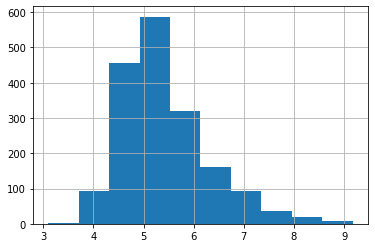

In [127]:
df_all.pchembl_value_Median.hist()

In [128]:
#save image
import matplotlib.pyplot as plt
plt.savefig("Images/Median Histogram Ligands")

<Figure size 432x288 with 0 Axes>

In [129]:
activity_class_mask = df_all.pchembl_value_Median >= 6.5
sum(activity_class_mask) / len(activity_class_mask)

0.11455981941309255

In [130]:
df_all['ActivityClass'] = activity_class_mask
df_all.head()

,Activity_ID,Quality,source,CID,SMILES,connectivity,InChIKey,InChI,InChI_AuxInfo,target_id,...,Descriptor_MorganFP_1017,Descriptor_MorganFP_1018,Descriptor_MorganFP_1019,Descriptor_MorganFP_1020,Descriptor_MorganFP_1021,Descriptor_MorganFP_1022,Descriptor_MorganFP_1023,TSNE_1,TSNE_2,ActivityClass
0,AADVGRCQGZZZNH_on_P18031_WT,High,ChEMBL30,CHEMBL363338;44397840;CHEMBL363338;44397840;CH...,CC(C)CC(CC(=O)C(Cc1ccc(OC(F)(F)C(=O)O)cc1)NC(=...,AADVGRCQGZZZNH,AADVGRCQGZZZNH-UHFFFAOYSA-N,InChI=1S/C45H47F2N3O10/c1-27(2)22-30(41(48)53)...,"""AuxInfo=1/1/N:1,3,37,36,38,49,56,48,55,35,39,...",P18031_WT,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,10.472835,33.717167,False
1,AAGZFGSRAZMRCS_on_P18031_WT,High,ChEMBL30,CHEMBL511000;CHEMBL511000;44563281;CHEMBL51100...,CC1(C)CCC2(C(=O)Nc3ccc(C(=O)O)cc3)CCC3(C)C(=CC...,AAGZFGSRAZMRCS,AAGZFGSRAZMRCS-UHFFFAOYSA-N,InChI=1S/C37H53NO4/c1-32(2)18-20-37(31(42)38-2...,"""AuxInfo=1/1/N:1,3,34,35,28,22,40,12,17,11,18,...",P18031_WT,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.718899,-56.344204,False
2,AATACZKOPAGNPL_on_P18031_WT,High,ChEMBL30,CHEMBL4160013,CCOc1ccc(OC(=O)CSc2nnc(-c3cc(O)c(O)cc3)o2)cc1,AATACZKOPAGNPL,AATACZKOPAGNPL-UHFFFAOYSA-N,InChI=1S/C18H16N2O6S/c1-2-24-12-4-6-13(7-5-12)...,"""AuxInfo=1/0/N:1,2,24,5,27,6,26,23,18,11,17,4,...",P18031_WT,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-36.759570,-3.386220,False
3,AAWBMDOJDQKGGQ_on_P18031_WT,High,ChEMBL30,CHEMBL3759405,CCCOc1ccc(-c2cccc(-c3noc(Cc4c[nH]c5ccccc45)n3)...,AAWBMDOJDQKGGQ,AAWBMDOJDQKGGQ-UHFFFAOYSA-N,InChI=1S/C25H22N4O2/c1-2-14-30-19-12-10-17(11-...,"""AuxInfo=1/0/N:1,2,25,24,11,26,23,10,12,7,30,6...",P18031_WT,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-54.528603,14.148515,False
4,ABDQNRCWGSGNBQ_on_P18031_WT,High,ChEMBL30,CHEMBL197929,O=C(O)COc1ccc(S(=O)(=O)N(Cc2ccc(C(F)(F)P(=O)(O...,ABDQNRCWGSGNBQ,ABDQNRCWGSGNBQ-UHFFFAOYSA-N,"InChI=1S/C21H20F2NO8PS2/c22-21(23,33(27,28)29)...","""AuxInfo=1/1/N:31,30,16,27,17,26,7,35,8,34,32,...",P18031_WT,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.027787,39.904415,False


In [131]:
cutoff_year = 2015
sum(df_all.Year >= cutoff_year) / len(df_all)

0.3182844243792325

In [132]:
df_all["TimeSplit"] = (df_all.Year >= cutoff_year).apply(lambda x : "Test" if x else "Train")
df_all

,Activity_ID,Quality,source,CID,SMILES,connectivity,InChIKey,InChI,InChI_AuxInfo,target_id,...,Descriptor_MorganFP_1018,Descriptor_MorganFP_1019,Descriptor_MorganFP_1020,Descriptor_MorganFP_1021,Descriptor_MorganFP_1022,Descriptor_MorganFP_1023,TSNE_1,TSNE_2,ActivityClass,TimeSplit
0,AADVGRCQGZZZNH_on_P18031_WT,High,ChEMBL30,CHEMBL363338;44397840;CHEMBL363338;44397840;CH...,CC(C)CC(CC(=O)C(Cc1ccc(OC(F)(F)C(=O)O)cc1)NC(=...,AADVGRCQGZZZNH,AADVGRCQGZZZNH-UHFFFAOYSA-N,InChI=1S/C45H47F2N3O10/c1-27(2)22-30(41(48)53)...,"""AuxInfo=1/1/N:1,3,37,36,38,49,56,48,55,35,39,...",P18031_WT,...,1.0,1.0,0.0,0.0,0.0,0.0,10.472835,33.717167,False,Train
1,AAGZFGSRAZMRCS_on_P18031_WT,High,ChEMBL30,CHEMBL511000;CHEMBL511000;44563281;CHEMBL51100...,CC1(C)CCC2(C(=O)Nc3ccc(C(=O)O)cc3)CCC3(C)C(=CC...,AAGZFGSRAZMRCS,AAGZFGSRAZMRCS-UHFFFAOYSA-N,InChI=1S/C37H53NO4/c1-32(2)18-20-37(31(42)38-2...,"""AuxInfo=1/1/N:1,3,34,35,28,22,40,12,17,11,18,...",P18031_WT,...,0.0,1.0,0.0,0.0,0.0,0.0,-1.718899,-56.344204,False,Train
2,AATACZKOPAGNPL_on_P18031_WT,High,ChEMBL30,CHEMBL4160013,CCOc1ccc(OC(=O)CSc2nnc(-c3cc(O)c(O)cc3)o2)cc1,AATACZKOPAGNPL,AATACZKOPAGNPL-UHFFFAOYSA-N,InChI=1S/C18H16N2O6S/c1-2-24-12-4-6-13(7-5-12)...,"""AuxInfo=1/0/N:1,2,24,5,27,6,26,23,18,11,17,4,...",P18031_WT,...,0.0,0.0,0.0,0.0,0.0,0.0,-36.759570,-3.386220,False,Test
3,AAWBMDOJDQKGGQ_on_P18031_WT,High,ChEMBL30,CHEMBL3759405,CCCOc1ccc(-c2cccc(-c3noc(Cc4c[nH]c5ccccc45)n3)...,AAWBMDOJDQKGGQ,AAWBMDOJDQKGGQ-UHFFFAOYSA-N,InChI=1S/C25H22N4O2/c1-2-14-30-19-12-10-17(11-...,"""AuxInfo=1/0/N:1,2,25,24,11,26,23,10,12,7,30,6...",P18031_WT,...,0.0,0.0,0.0,0.0,0.0,0.0,-54.528603,14.148515,False,Test
4,ABDQNRCWGSGNBQ_on_P18031_WT,High,ChEMBL30,CHEMBL197929,O=C(O)COc1ccc(S(=O)(=O)N(Cc2ccc(C(F)(F)P(=O)(O...,ABDQNRCWGSGNBQ,ABDQNRCWGSGNBQ-UHFFFAOYSA-N,"InChI=1S/C21H20F2NO8PS2/c22-21(23,33(27,28)29)...","""AuxInfo=1/1/N:31,30,16,27,17,26,7,35,8,34,32,...",P18031_WT,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.027787,39.904415,False,Train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1767,ZZLZHWBNIIKVOG_on_P18031_WT,High,ChEMBL30,CHEMBL3974642;CHEMBL3903731;CHEMBL3974642;CHEM...,CC(C)CC(c1c(O)c(C=O)c(O)c(C=O)c1O)C1CCC(C)C2(C...,ZZLZHWBNIIKVOG,ZZLZHWBNIIKVOG-UHFFFAOYSA-N,InChI=1S/C28H38O5/c1-14(2)11-17(22-24(32)18(12...,"""AuxInfo=1/0/N:1,3,23,32,33,25,21,20,27,28,4,1...",P18031_WT,...,0.0,1.0,0.0,0.0,0.0,0.0,-1.022240,-17.512543,False,Test
1768,ZZQGXJVGZKQIGN_on_P18031_WT,High,ChEMBL30,CHEMBL3402418,O=C(OC1CSSC1)c1ccc(CCCCCCOC(=O)c2c(Br)ccc(Br)c...,ZZQGXJVGZKQIGN,ZZQGXJVGZKQIGN-UHFFFAOYSA-N,InChI=1S/C23H24Br2O4S2/c24-18-10-11-21(25)20(1...,"""AuxInfo=1/0/N:15,16,14,17,13,11,30,10,31,26,2...",P18031_WT,...,0.0,1.0,0.0,0.0,0.0,0.0,6.102679,-5.045501,False,Test
1769,ZZTBNXDDDGFULL_on_P18031_WT,High,ChEMBL30,CHEMBL1778901,CCCCOc1ccc(C(=O)C=Cc2c(OC)cc(O)c(Br)c2)cc1,ZZTBNXDDDGFULL,ZZTBNXDDDGFULL-UHFFFAOYSA-N,InChI=1S/C20H21BrO4/c1-3-4-11-25-16-8-5-14(6-9...,"""AuxInfo=1/0/N:1,17,2,3,8,24,13,7,25,12,4,23,1...",P18031_WT,...,0.0,0.0,0.0,0.0,0.0,0.0,16.477085,-23.673544,False,Train
1770,ZZTYPLSBNNGEIS_on_P18031_WT,High,ChEMBL30,CHEMBL486986,CC1CCC2(C(=O)O)CCC3(C)C(=CCC4C5(C)CCC(O)C(C)(C...,ZZTYPLSBNNGEIS,ZZTYPLSBNNGEIS-UHFFFAOYSA-N,InChI=1S/C30H48O4/c1-18-10-15-30(24(32)33)17-1...,"""AuxInfo=1/1/N:1,24,25,18,12,30,33,14,15,3,27,...",P18031_WT,...,0.0,1.0,0.0,0.0,0.0,0.0,0.114998,-53.091130,False,Train


In [92]:
os.getcwd()

'/content/drive/MyDrive/ACMDD/DeNovo/data'

In [111]:
from scaffviz.data.papyrus import Papyrus
from scaffviz.clustering.descriptors import MorganFP
from scaffviz.depiction.plot import Plot
from scaffviz.clustering.manifold import TSNE

In [133]:
from scaffviz.data.dataset import DataSetTSV

dataset = DataSetTSV(data=df_all, path='data/PTP1B_LIGANDS_qsar.tsv')

In [115]:
DataSetTSV('data/PTP1B_LIGANDS_qsar.tsv').asDataFrame().head()

,Activity_ID,Quality,source,CID,SMILES,connectivity,InChIKey,InChI,InChI_AuxInfo,target_id,...,pchembl_value,pchembl_value_Mean,pchembl_value_StdDev,pchembl_value_SEM,pchembl_value_N,pchembl_value_Median,pchembl_value_MAD,ActivityClass,TimeSplit,RDMol
0,AADVGRCQGZZZNH_on_P18031_WT,High,ChEMBL30,CHEMBL363338;44397840;CHEMBL363338;44397840;CH...,CC(C)CC(CC(=O)C(Cc1ccc(OC(F)(F)C(=O)O)cc1)NC(=...,AADVGRCQGZZZNH,AADVGRCQGZZZNH-UHFFFAOYSA-N,InChI=1S/C45H47F2N3O10/c1-27(2)22-30(41(48)53)...,"""AuxInfo=1/1/N:1,3,37,36,38,49,56,48,55,35,39,...",P18031_WT,...,5.42;5.42;5.42;5.42;5.42;5.42;5.42;5.42,5.42,0.0,0.0,8.0,5.42,0.0,False,Train,<rdkit.Chem.rdchem.Mol object at 0x7fb0d7055da0>
1,AAGZFGSRAZMRCS_on_P18031_WT,High,ChEMBL30,CHEMBL511000;CHEMBL511000;44563281;CHEMBL51100...,CC1(C)CCC2(C(=O)Nc3ccc(C(=O)O)cc3)CCC3(C)C(=CC...,AAGZFGSRAZMRCS,AAGZFGSRAZMRCS-UHFFFAOYSA-N,InChI=1S/C37H53NO4/c1-32(2)18-20-37(31(42)38-2...,"""AuxInfo=1/1/N:1,3,34,35,28,22,40,12,17,11,18,...",P18031_WT,...,5.51;5.51;5.51;5.51;5.51;5.51;5.51;5.51;5.51;5...,5.51,0.0,0.0,12.0,5.51,0.0,False,Train,<rdkit.Chem.rdchem.Mol object at 0x7fb0f1602df0>
2,AATACZKOPAGNPL_on_P18031_WT,High,ChEMBL30,CHEMBL4160013,CCOc1ccc(OC(=O)CSc2nnc(-c3cc(O)c(O)cc3)o2)cc1,AATACZKOPAGNPL,AATACZKOPAGNPL-UHFFFAOYSA-N,InChI=1S/C18H16N2O6S/c1-2-24-12-4-6-13(7-5-12)...,"""AuxInfo=1/0/N:1,2,24,5,27,6,26,23,18,11,17,4,...",P18031_WT,...,5.1;5.1,5.10,0.0,0.0,2.0,5.10,0.0,False,Test,<rdkit.Chem.rdchem.Mol object at 0x7fb0f00c4580>
3,AAWBMDOJDQKGGQ_on_P18031_WT,High,ChEMBL30,CHEMBL3759405,CCCOc1ccc(-c2cccc(-c3noc(Cc4c[nH]c5ccccc45)n3)...,AAWBMDOJDQKGGQ,AAWBMDOJDQKGGQ-UHFFFAOYSA-N,InChI=1S/C25H22N4O2/c1-2-14-30-19-12-10-17(11-...,"""AuxInfo=1/0/N:1,2,25,24,11,26,23,10,12,7,30,6...",P18031_WT,...,5.01;5.01,5.01,0.0,0.0,2.0,5.01,0.0,False,Test,<rdkit.Chem.rdchem.Mol object at 0x7fb0f00c4120>
4,ABDQNRCWGSGNBQ_on_P18031_WT,High,ChEMBL30,CHEMBL197929,O=C(O)COc1ccc(S(=O)(=O)N(Cc2ccc(C(F)(F)P(=O)(O...,ABDQNRCWGSGNBQ,ABDQNRCWGSGNBQ-UHFFFAOYSA-N,"InChI=1S/C21H20F2NO8PS2/c22-21(23,33(27,28)29)...","""AuxInfo=1/1/N:31,30,16,27,17,26,7,35,8,34,32,...",P18031_WT,...,6.0;6.0,6.00,0.0,0.0,2.0,6.00,0.0,False,Train,<rdkit.Chem.rdchem.Mol object at 0x7fb0f00c4530>


In [134]:
plot = Plot(dataset, TSNE())
plot.plot(
    recalculate=False, 
    color_by="TimeSplit",
    color_style="groups",
    card_data=["pchembl_value_Median", "all_doc_ids", "source"],
    title_data="Activity_ID",
    viewport_height=800,
    port=9192
    
)

<IPython.core.display.Javascript object>

In [135]:
df_test = df_all[df_all.TimeSplit == "Test"]
len(df_test)

564

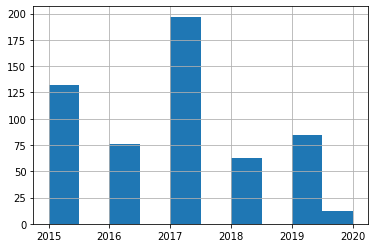

In [136]:
df_test.Year.hist()

In [137]:
#save image
plt.savefig("Images/Year Histogram")

<Figure size 432x288 with 0 Axes>

In [138]:
df_train = df_all[df_all.TimeSplit == "Train"]
len(df_train)

1208

In [139]:
X = df_train[df_train.columns[df_train.columns.str.startswith("Descriptor_")]]
X

,Descriptor_MorganFP_0,Descriptor_MorganFP_1,Descriptor_MorganFP_2,Descriptor_MorganFP_3,Descriptor_MorganFP_4,Descriptor_MorganFP_5,Descriptor_MorganFP_6,Descriptor_MorganFP_7,Descriptor_MorganFP_8,Descriptor_MorganFP_9,...,Descriptor_MorganFP_1014,Descriptor_MorganFP_1015,Descriptor_MorganFP_1016,Descriptor_MorganFP_1017,Descriptor_MorganFP_1018,Descriptor_MorganFP_1019,Descriptor_MorganFP_1020,Descriptor_MorganFP_1021,Descriptor_MorganFP_1022,Descriptor_MorganFP_1023
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1764,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1765,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1770,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [140]:
y = df_train.ActivityClass
y

0       False
1       False
4       False
5       False
7       False
        ...  
1764    False
1765    False
1769    False
1770    False
1771    False
Name: ActivityClass, Length: 1208, dtype: bool

In [141]:
from sklearn.ensemble import ExtraTreesClassifier

classifier = ExtraTreesClassifier(n_estimators=250)

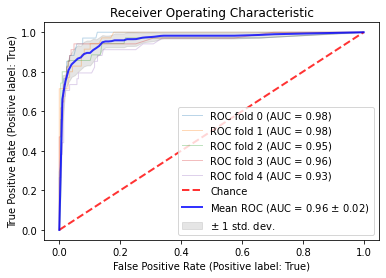

In [142]:
# adapted from https://scikit-learn.org/stable/modules/cross_validation.html

import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X.iloc[train], y.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X.iloc[test],
        y.iloc[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver Operating Characteristic",
)
ax.legend(loc="lower right")
plt.show()

In [143]:
#save image
plt.savefig("Images/ROC")

<Figure size 432x288 with 0 Axes>

In [144]:
model = classifier.fit(X, y)

In [145]:
X_test = df_test[df_test.columns[df_test.columns.str.startswith("Descriptor_")]]

predictions = classifier.predict(X_test)
predictions[0:10]

array([False, False, False, False, False, False, False, False, False,
       False])

In [146]:
predictions_proba = classifier.predict_proba(X_test)[::,1]
predictions_proba[0:10]

array([0.004, 0.056, 0.016, 0.024, 0.068, 0.1  , 0.028, 0.032, 0.064,
       0.12 ])

In [147]:
y_test = df_test.ActivityClass
y_test

2       False
3       False
6        True
21      False
26      False
        ...  
1751    False
1762    False
1766    False
1767    False
1768    False
Name: ActivityClass, Length: 564, dtype: bool

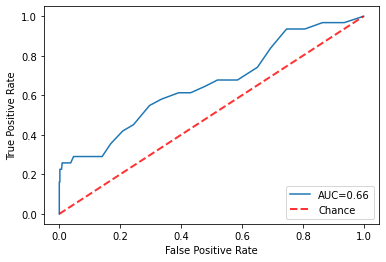

In [148]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test,  predictions_proba)
auc = roc_auc_score(y_test, predictions_proba)

plt.plot(fpr,tpr, label=f"AUC={auc:2.2}")
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [149]:
#save image
plt.savefig("Images/AUC Positives Rate")

<Figure size 432x288 with 0 Axes>

In [150]:
from sklearn.metrics import matthews_corrcoef

matthews_corrcoef(y_test, predictions)

0.30322287021579997

In [151]:
X = dataset.getDescriptors()
y = dataset.getSubset(('ActivityClass',)).iloc[::,0]

In [152]:
classifier.fit(X, y)
classifier

ExtraTreesClassifier(n_estimators=250)

In [153]:
data_dir = 'data/qsar/models/'
data_file = os.path.join(data_dir, 'PTP1B_CLS_ET_250.pickle')
os.makedirs(data_dir, exist_ok=True)
joblib.dump(classifier, data_file)

['data/qsar/models/PTP1B_CLS_ET_250.pickle']

In [154]:
model = joblib.load(data_file)
model

ExtraTreesClassifier(n_estimators=250)

In [161]:
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu117


In [159]:
! unzip -n 'drugex/models/pretrained/DrugEx_v2_PT_Papyrus05.5.zip' -d 'drugex/models/pretrained/DrugEx_v2_PT_Papyrus05.5'

Archive:  drugex/models/pretrained/DrugEx_v2_PT_Papyrus05.5.zip
   creating: drugex/models/pretrained/DrugEx_v2_PT_Papyrus05.5/model_pretraining/
  inflating: drugex/models/pretrained/DrugEx_v2_PT_Papyrus05.5/model_pretraining/command.txt  
  inflating: drugex/models/pretrained/DrugEx_v2_PT_Papyrus05.5/model_pretraining/Papyrus05.5_smiles_rnn_PT.json  
  inflating: drugex/models/pretrained/DrugEx_v2_PT_Papyrus05.5/model_pretraining/Papyrus05.5_smiles_rnn_PT.log  
  inflating: drugex/models/pretrained/DrugEx_v2_PT_Papyrus05.5/model_pretraining/Papyrus05.5_smiles_rnn_PT_fit.tsv  
  inflating: drugex/models/pretrained/DrugEx_v2_PT_Papyrus05.5/model_pretraining/Papyrus05.5_smiles_rnn_PT_smiles.tsv  
  inflating: drugex/models/pretrained/DrugEx_v2_PT_Papyrus05.5/Papyrus05.5_smiles_rnn_PT.pkg  
  inflating: drugex/models/pretrained/DrugEx_v2_PT_Papyrus05.5/Papyrus05.5_smiles_rnn_PT.vocab  
  inflating: drugex/models/pretrained/DrugEx_v2_PT_Papyrus05.5/README.txt  
   creating: drugex/models/

In [162]:
from drugex.training.models import RNN
from drugex.data.corpus.vocabulary import VocSmiles

PT_MODEL_FOLDER = "drugex/models/pretrained/DrugEx_v2_PT_Papyrus05.5/"
GPUS = [0] # we will use only one GPU with ID=0, but if you have more, you can list more GPU IDs here

voc = VocSmiles.fromFile(os.path.join(PT_MODEL_FOLDER, "Papyrus05.5_smiles_rnn_PT.vocab"))
pretrained = RNN(voc, is_lstm=True, use_gpus=GPUS)
pretrained.loadStatesFromFile(os.path.join(PT_MODEL_FOLDER, "Papyrus05.5_smiles_rnn_PT.pkg"))

In [163]:
from drugex.utils import canonicalize_list
from drugex.training.scorers.smiles import SmilesChecker

def sample_smiles(self, num_smiles, batch_size=100, drop_duplicates=True, drop_invalid=True):
    smiles = []
    while len(smiles) < num_smiles:
        # sample SMILES
        sequences = self.sample(batch_size)
        # decode according to vocabulary
        new_smiles = canonicalize_list([self.voc.decode(s, is_tk = False) for s in sequences])
        # drop duplicates
        if drop_duplicates:
            new_smiles = np.array(new_smiles)
            new_smiles = new_smiles[np.logical_not(np.isin(new_smiles, smiles))]
            new_smiles = new_smiles.tolist()
        # drop invalid smiles
        if drop_invalid:
            scores = SmilesChecker.checkSmiles(new_smiles, frags=None).ravel()
            new_smiles = np.array(new_smiles)[scores > 0].tolist()
        smiles += new_smiles
    return smiles[:num_smiles]

smiles_pretrained = sample_smiles(pretrained, 1000)
print(smiles_pretrained[0:10])

['CCOc1ccc(NC(=O)CCn2nc(-c3ccc(OC)cc3)ccc2=O)cc1', 'CC1CCN(C(=O)c2c(O)nc(-c3ccccc3)nc2C(C)C)CC1', 'CCC1(CN(C)C)CC(=O)N(C2CCCCC2)O1', 'O=C(O)c1ccc(F)c2c1CC(=Cc1ccco1)C2=O', 'Cn1c(Nc2c(Cl)ccc(CNC(=O)C(C)(F)F)c2Cl)nc2cc(C(=O)NC3CCC(=O)C3)c(N3CCC(C(F)(F)F)CC3)cc21', 'O=C(Cc1c[nH]c2ccccc12)NC1CCN(Cc2ccc(F)cc2)CC1', 'CN1CCc2nc(C(=O)NC3CCCN(C(=O)N4CCCC4)C3)sc2C1', 'COCCCn1c(=O)c(CC(C)(C)C)nc2ccc(-c3cc(C)nc(OC)c3)nc21', 'O=C(Nc1cc2c(nc1-c1ccc(F)c(F)c1)sc1ccccc12)c1ccc(F)cc1', 'CC(O)C#Cc1ccc2c(c1)CCn1c-2cc(OCC2COCCO2)nc1=O']


In [164]:
from scaffviz.data.dataset import DataSetSMILES

dataset = DataSetSMILES("data/pretrained_sampled.tsv", smiles=smiles_pretrained, use_existing=False)
dataset.asDataFrame().head(3)

,SMILES,RDMol
0,CCOc1ccc(NC(=O)CCn2nc(-c3ccc(OC)cc3)ccc2=O)cc1,<rdkit.Chem.rdchem.Mol object at 0x7fb0eca977b0>
1,CC1CCN(C(=O)c2c(O)nc(-c3ccccc3)nc2C(C)C)CC1,<rdkit.Chem.rdchem.Mol object at 0x7fb0eca972b0>
2,CCC1(CN(C)C)CC(=O)N(C2CCCCC2)O1,<rdkit.Chem.rdchem.Mol object at 0x7fb0eca900d0>


In [165]:
from scaffviz.depiction.plot import Plot
from scaffviz.clustering.manifold import TSNE
from scaffviz.clustering.descriptors import MorganFP

dataset.addDescriptors([MorganFP(radius=2, nBits=1024)], recalculate=False) 

# make an interactive plot that will use t-SNE to embed the data set in 2D (all current descriptors in the data set will be used)
plt = Plot(dataset, TSNE())

# start the server, you can open the plot in the browser
plt.plot(
    recalculate=False,
    viewport_height=800,
    port=9292
)

<IPython.core.display.Javascript object>

In [166]:
df_ptp1b = pd.read_table('data/PTP1B_LIGANDS.tsv')
df_ptp1b

,Activity_ID,Quality,source,CID,SMILES,connectivity,InChIKey,InChI,InChI_AuxInfo,target_id,...,Descriptor_MorganFP_1016,Descriptor_MorganFP_1017,Descriptor_MorganFP_1018,Descriptor_MorganFP_1019,Descriptor_MorganFP_1020,Descriptor_MorganFP_1021,Descriptor_MorganFP_1022,Descriptor_MorganFP_1023,TSNE_1,TSNE_2
0,AADVGRCQGZZZNH_on_P18031_WT,High,ChEMBL30,CHEMBL363338;44397840;CHEMBL363338;44397840;CH...,CC(C)CC(CC(=O)C(Cc1ccc(OC(F)(F)C(=O)O)cc1)NC(=...,AADVGRCQGZZZNH,AADVGRCQGZZZNH-UHFFFAOYSA-N,InChI=1S/C45H47F2N3O10/c1-27(2)22-30(41(48)53)...,"""AuxInfo=1/1/N:1,3,37,36,38,49,56,48,55,35,39,...",P18031_WT,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,10.472835,33.717167
1,AAGZFGSRAZMRCS_on_P18031_WT,High,ChEMBL30,CHEMBL511000;CHEMBL511000;44563281;CHEMBL51100...,CC1(C)CCC2(C(=O)Nc3ccc(C(=O)O)cc3)CCC3(C)C(=CC...,AAGZFGSRAZMRCS,AAGZFGSRAZMRCS-UHFFFAOYSA-N,InChI=1S/C37H53NO4/c1-32(2)18-20-37(31(42)38-2...,"""AuxInfo=1/1/N:1,3,34,35,28,22,40,12,17,11,18,...",P18031_WT,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.718899,-56.344204
2,AATACZKOPAGNPL_on_P18031_WT,High,ChEMBL30,CHEMBL4160013,CCOc1ccc(OC(=O)CSc2nnc(-c3cc(O)c(O)cc3)o2)cc1,AATACZKOPAGNPL,AATACZKOPAGNPL-UHFFFAOYSA-N,InChI=1S/C18H16N2O6S/c1-2-24-12-4-6-13(7-5-12)...,"""AuxInfo=1/0/N:1,2,24,5,27,6,26,23,18,11,17,4,...",P18031_WT,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-36.759570,-3.386220
3,AAWBMDOJDQKGGQ_on_P18031_WT,High,ChEMBL30,CHEMBL3759405,CCCOc1ccc(-c2cccc(-c3noc(Cc4c[nH]c5ccccc45)n3)...,AAWBMDOJDQKGGQ,AAWBMDOJDQKGGQ-UHFFFAOYSA-N,InChI=1S/C25H22N4O2/c1-2-14-30-19-12-10-17(11-...,"""AuxInfo=1/0/N:1,2,25,24,11,26,23,10,12,7,30,6...",P18031_WT,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-54.528603,14.148515
4,ABDQNRCWGSGNBQ_on_P18031_WT,High,ChEMBL30,CHEMBL197929,O=C(O)COc1ccc(S(=O)(=O)N(Cc2ccc(C(F)(F)P(=O)(O...,ABDQNRCWGSGNBQ,ABDQNRCWGSGNBQ-UHFFFAOYSA-N,"InChI=1S/C21H20F2NO8PS2/c22-21(23,33(27,28)29)...","""AuxInfo=1/1/N:31,30,16,27,17,26,7,35,8,34,32,...",P18031_WT,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.027787,39.904415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1767,ZZLZHWBNIIKVOG_on_P18031_WT,High,ChEMBL30,CHEMBL3974642;CHEMBL3903731;CHEMBL3974642;CHEM...,CC(C)CC(c1c(O)c(C=O)c(O)c(C=O)c1O)C1CCC(C)C2(C...,ZZLZHWBNIIKVOG,ZZLZHWBNIIKVOG-UHFFFAOYSA-N,InChI=1S/C28H38O5/c1-14(2)11-17(22-24(32)18(12...,"""AuxInfo=1/0/N:1,3,23,32,33,25,21,20,27,28,4,1...",P18031_WT,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.022240,-17.512543
1768,ZZQGXJVGZKQIGN_on_P18031_WT,High,ChEMBL30,CHEMBL3402418,O=C(OC1CSSC1)c1ccc(CCCCCCOC(=O)c2c(Br)ccc(Br)c...,ZZQGXJVGZKQIGN,ZZQGXJVGZKQIGN-UHFFFAOYSA-N,InChI=1S/C23H24Br2O4S2/c24-18-10-11-21(25)20(1...,"""AuxInfo=1/0/N:15,16,14,17,13,11,30,10,31,26,2...",P18031_WT,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.102679,-5.045501
1769,ZZTBNXDDDGFULL_on_P18031_WT,High,ChEMBL30,CHEMBL1778901,CCCCOc1ccc(C(=O)C=Cc2c(OC)cc(O)c(Br)c2)cc1,ZZTBNXDDDGFULL,ZZTBNXDDDGFULL-UHFFFAOYSA-N,InChI=1S/C20H21BrO4/c1-3-4-11-25-16-8-5-14(6-9...,"""AuxInfo=1/0/N:1,17,2,3,8,24,13,7,25,12,4,23,1...",P18031_WT,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.477085,-23.673544
1770,ZZTYPLSBNNGEIS_on_P18031_WT,High,ChEMBL30,CHEMBL486986,CC1CCC2(C(=O)O)CCC3(C)C(=CCC4C5(C)CCC(O)C(C)(C...,ZZTYPLSBNNGEIS,ZZTYPLSBNNGEIS-UHFFFAOYSA-N,InChI=1S/C30H48O4/c1-18-10-15-30(24(32)33)17-1...,"""AuxInfo=1/1/N:1,24,25,18,12,30,33,14,15,3,27,...",P18031_WT,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.114998,-53.091130


In [167]:
smiles_train = df_ptp1b.SMILES
smiles_train

0       CC(C)CC(CC(=O)C(Cc1ccc(OC(F)(F)C(=O)O)cc1)NC(=...
1       CC1(C)CCC2(C(=O)Nc3ccc(C(=O)O)cc3)CCC3(C)C(=CC...
2           CCOc1ccc(OC(=O)CSc2nnc(-c3cc(O)c(O)cc3)o2)cc1
3       CCCOc1ccc(-c2cccc(-c3noc(Cc4c[nH]c5ccccc45)n3)...
4       O=C(O)COc1ccc(S(=O)(=O)N(Cc2ccc(C(F)(F)P(=O)(O...
                              ...                        
1767    CC(C)CC(c1c(O)c(C=O)c(O)c(C=O)c1O)C1CCC(C)C2(C...
1768    O=C(OC1CSSC1)c1ccc(CCCCCCOC(=O)c2c(Br)ccc(Br)c...
1769           CCCCOc1ccc(C(=O)C=Cc2c(OC)cc(O)c(Br)c2)cc1
1770    CC1CCC2(C(=O)O)CCC3(C)C(=CCC4C5(C)CCC(O)C(C)(C...
1771    CC(C)(C)OC(=O)COc1ccc(CC2=C(c3ccccc3)c3ccccc3C...
Name: SMILES, Length: 1772, dtype: object

In [168]:
from drugex.data.processing import Standardization

N_PROCESSES = 12 # number of CPU cores to use
CHUNK_SIZE = 1000 # largest chunk per CPU core (regulates RAM usage)

standardizer = Standardization(n_proc=N_PROCESSES, chunk_size=CHUNK_SIZE)
smiles_train = standardizer.apply(smiles_train)
smiles_train[0:10]

Standardizing molecules (batch processing):   0%|          | 0/1 [00:00<?, ?it/s]

['CC(C)CC(CC(=O)C(Cc1ccc(OC(F)(F)C(=O)O)cc1)NC(=O)C(CCC(=O)OCc1ccccc1)NC(=O)OCC1c2ccccc2-c2ccccc21)C(N)=O',
 'CC1(C)CCC2(C(=O)Nc3ccc(C(=O)O)cc3)CCC3(C)C(=CCC4C5(C)CCC(O)C(C)(C)C5CCC43C)C2C1',
 'CCOc1ccc(OC(=O)CSc2nnc(-c3ccc(O)c(O)c3)o2)cc1',
 'CCCOc1ccc(-c2cccc(-c3noc(Cc4c[nH]c5ccccc45)n3)n2)cc1',
 'O=C(O)COc1ccc(S(=O)(=O)N(Cc2ccc(C(F)(F)P(=O)(O)O)cc2)Cc2cccs2)cc1',
 'CCOS(=O)(=O)C=Cc1ccc(OCCCCNc2nc(-c3ccc(Br)cc3)cs2)cc1',
 'CCOc1cc(NS(C)(=O)=O)c(OCC)cc1CNC(=O)Nc1ccc(C)cc1',
 'O=C(O)c1ccc(N2C(=O)C(=CC=Cc3ccccc3)SC2=S)cc1',
 'CC(C)=CCc1cc(C2CC(=O)c3ccc(O)cc3O2)cc2c1OC(C)(C)C(O)C2',
 'O=C(O)C(Cc1ccccc1)Oc1ccc(-c2ccc(-c3c(Cc4ccccc4)sc4ccccc34)cc2)cc1Br']

In [169]:
from drugex.data.processing import CorpusEncoder, RandomTrainTestSplitter
from drugex.data.corpus.corpus import SequenceCorpus
from drugex.data.datasets import SmilesDataSet
from drugex.logs import logger
logger.setLevel('ERROR')

DATA_DIR = "drugex/sets/"
os.makedirs(DATA_DIR, exist_ok=True)

voc = VocSmiles.fromFile("drugex/models/pretrained/DrugEx_v2_PT_Papyrus05.5/Papyrus05.5_smiles_rnn_PT.vocab")
encoder = CorpusEncoder( # CorpusEcoder uses the supplied corpus class to encode tokens for the new data set
    SequenceCorpus, # The corpus class implements how each SMILES string is divided into words by the vocabulary
    {
        # arguments of the SequenceCorpus
        'vocabulary': voc, # used vocabulary
        'update_voc': False, # if False, the vocabulary stays fixed (no new tokens are added to it)
        'throw': True # compounds containing unknown tokens are thrown out of the resulting data set

    },
    n_proc=N_PROCESSES,
    chunk_size=CHUNK_SIZE
)

data_collector = SmilesDataSet(os.path.join(DATA_DIR, 'ligand_corpus.tsv'), rewrite=True)
encoder.apply(smiles_train, collector=data_collector)

SequenceCorpus (batch processing):   0%|          | 0/1 [00:00<?, ?it/s]

In [170]:
splitter = RandomTrainTestSplitter(0.1, 1e4)
train, test = splitter(data_collector.getData())
for df, name in zip([train, test], ['train', 'test']):
    df.to_csv(os.path.join(DATA_DIR, f'ligand_{name}.tsv'), header=True, index=False, sep='\t')

voc.toFile(os.path.join(DATA_DIR, 'ligand.vocab'))

In [171]:
BATCH_SIZE = 256

data_set_train = SmilesDataSet(os.path.join(DATA_DIR, 'ligand_train.tsv'), voc=voc)
data_set_train.voc = voc
train_loader = data_set_train.asDataLoader(batch_size=BATCH_SIZE)

data_set_test = SmilesDataSet(os.path.join(DATA_DIR, 'ligand_test.tsv'), voc=voc)
data_set_test.voc = voc
valid_loader = data_set_test.asDataLoader(batch_size=BATCH_SIZE)

In [172]:
from drugex.training.monitors import FileMonitor

MODEL_DIR = "drugex/models/finetuned/"

ft_path = os.path.join(MODEL_DIR, 'ligand_finetune')
finetuned = RNN(voc, is_lstm=True, use_gpus=GPUS)
finetuned.loadStatesFromFile(os.path.join(PT_MODEL_FOLDER, 'Papyrus05.5_smiles_rnn_PT.pkg'))
monitor = FileMonitor(ft_path, verbose=True)
finetuned.fit(train_loader, valid_loader, epochs=10, monitor=monitor)

voc.toFile(os.path.join(MODEL_DIR, 'finetune.vocab'))

In [173]:
df_info = pd.read_csv('drugex/models/finetuned/ligand_finetune_fit.tsv', sep='\t')
df_info.head()

,epoch,loss_train,loss_valid,valid_ratio,unique_ratio,desire_ratio,mean_train_loss
0,1,0.180153,0.185336,1.000000,NaN,NaN,NaN
1,2,0.143994,0.180419,1.000000,NaN,NaN,NaN
2,3,0.143588,0.179830,1.000000,NaN,NaN,NaN
3,4,0.111561,0.180211,1.000000,NaN,NaN,NaN
4,5,0.105357,0.180051,0.923077,NaN,NaN,NaN


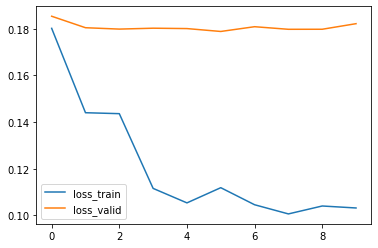

In [174]:
df_info[['loss_train', 'loss_valid']].plot.line()

In [176]:
#save image
import matplotlib.pyplot as plt
plt.savefig('Images/loss train valid')

<Figure size 432x288 with 0 Axes>

In [177]:
finetuned.loadStatesFromFile('drugex/models/finetuned/ligand_finetune.pkg')

smiles_finetuned = sample_smiles(finetuned, 1000)

dataset = DataSetSMILES("data/finetuned_sampled.tsv", smiles=smiles_finetuned, use_existing=False)
dataset.addDescriptors([MorganFP(radius=2, nBits=1024)], recalculate=False) 

plt = Plot(dataset, TSNE())
plt.plot(
    recalculate=False,
    viewport_height=800,
    port=9393
)

<IPython.core.display.Javascript object>

In [178]:
import joblib

model = joblib.load('data/qsar/models/PTP1B_CLS_ET_250.pickle')
model

ExtraTreesClassifier(n_estimators=250)

In [179]:
from drugex.training.interfaces import Scorer

class ModelScorer(Scorer):
    
    def __init__(self, model, prefix, descriptor = MorganFP(radius=2, nBits=1024)):
        super().__init__()
        self.model = model
        self.prefix = prefix
        self.descriptor = descriptor
    
    def getScores(self, mols, frags=None):
        X = pd.Series(mols).apply(lambda x : pd.Series(self.descriptor(x) if x else [0] * 1024))
        preds = self.model.predict_proba(X)[::,1]
        return preds
    
    def getKey(self):
        return f"{self.prefix}_MS"



scorer_model = ModelScorer(model, 'PTP1B_CLS')
scorer_model

In [180]:
predictions = scorer_model(smiles_finetuned)
predictions[0:10]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names



array([0.008, 0.   , 0.   , 0.036, 0.044, 0.008, 0.02 , 0.008, 0.   ,
       0.06 ])

In [181]:
sum(predictions > 0.5) / len(predictions)

0.051

In [182]:
from drugex.training.scorers.properties import Property

sascore = Property("SA")

In [183]:
from drugex.training.scorers.modifiers import ClippedScore

scorer_model.setModifier(ClippedScore(lower_x=0.2, upper_x=0.8))

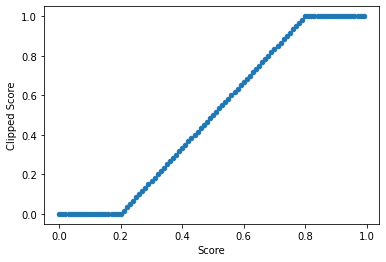

In [184]:
def depict_modifier(modifier, start=0, end=1, step=0.01, name = 'Clipped Score'):
    vals = np.arange(start,end, step)
    scores = [(x, modifier(x)) for x in vals] # get the A1R modifier for inactivity (the lower the activity, the higher the reward)
    scores = pd.DataFrame(scores, columns=['Score', name])
    return scores.plot.scatter(x = 'Score', y = name)

depict_modifier(scorer_model.getModifier())

In [186]:
#save image
import matplotlib.pyplot as plt
plt.savefig("Images/Clipped score")

<Figure size 432x288 with 0 Axes>

In [187]:
from drugex.training.scorers.modifiers import SmoothClippedScore

sascore.setModifier(SmoothClippedScore(lower_x=5, upper_x=3))

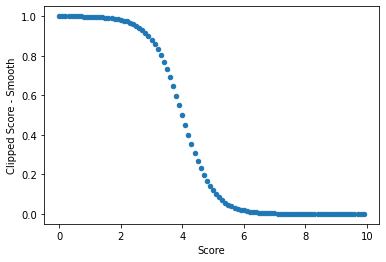

In [188]:
depict_modifier(sascore.getModifier(), 0, 10, 0.1, 'Clipped Score - Smooth')

In [189]:
#save image
plt.savefig("Images/Clipped score smooth")

<Figure size 432x288 with 0 Axes>

In [190]:
from drugex.training.environment import DrugExEnvironment
from drugex.training.rewards import ParetoCrowdingDistance

scorers = [
    scorer_model,
    sascore
]
thresholds = [
    0.5,
    0.1
]

environment = DrugExEnvironment(scorers, thresholds, reward_scheme=ParetoCrowdingDistance())

In [191]:
scores = environment.getScores(smiles_finetuned)
scores

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names



,PTP1B_CLS_MS,SA,DESIRE,VALID
0,0.000000,0.975163,0,1
1,0.000000,0.973120,0,1
2,0.000000,0.155999,0,1
3,0.000000,0.931988,0,1
4,0.000000,0.413409,0,1
...,...,...,...,...
995,0.000000,0.947487,0,1
996,0.086667,0.904018,0,1
997,0.000000,0.974546,0,1
998,0.753333,0.830199,1,1


In [192]:
sum(scores["DESIRE"]) / len(scores)

0.051

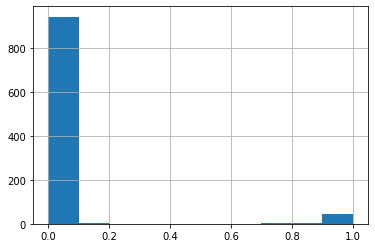

In [193]:
scores.PTP1B_CLS_MS.hist()

In [194]:
#save image
import matplotlib.pyplot as plt
plt.savefig("Images/PTP1B_CLS_hist")

<Figure size 432x288 with 0 Axes>

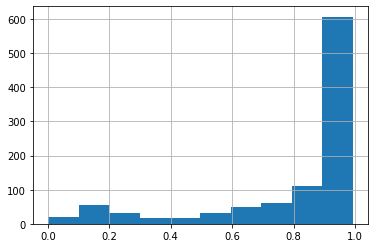

In [195]:
scores.SA.hist()

In [196]:
#save image
import matplotlib.pyplot as plt
plt.savefig("Images/Sa_histogram")

<Figure size 432x288 with 0 Axes>

In [197]:
from drugex.training.models.explorer import SmilesExplorerNoFrag
import warnings
warnings.filterwarnings('ignore')

pretrained = RNN(voc, is_lstm=True, use_gpus=GPUS)
pretrained.loadStatesFromFile('drugex/models/pretrained/DrugEx_v2_PT_Papyrus05.5/Papyrus05.5_smiles_rnn_PT.pkg')

finetuned = RNN(voc, is_lstm=True, use_gpus=GPUS)
finetuned.loadStatesFromFile('drugex/models/finetuned/ligand_finetune.pkg')

explorer = SmilesExplorerNoFrag(
    agent = finetuned,
    env = environment,
    mutate = pretrained, # network introducing mutations to the generated structures (rate determined by epsilon)
    epsilon = 0.05,
    use_gpus = GPUS
)

In [198]:
monitor = FileMonitor(os.path.join(MODEL_DIR, 'ligand_agent_rl'), verbose=True)
explorer.fit(train_loader, valid_loader, monitor=monitor, epochs=30)

In [200]:
df_info = pd.read_csv('drugex/models/finetuned/ligand_agent_rl_fit.tsv', sep='\t')
df_info.head()

,epoch,loss_train,loss_valid,valid_ratio,unique_ratio,desire_ratio,mean_train_loss
0,1,NaN,NaN,0.898438,NaN,0.007812,-1.419641
1,2,NaN,NaN,0.867188,NaN,0.000000,-0.101761
2,3,NaN,NaN,0.921875,NaN,0.007812,-0.102139
3,4,NaN,NaN,0.921875,NaN,0.000000,-0.098880
4,5,NaN,NaN,0.937500,NaN,0.000000,-0.092632


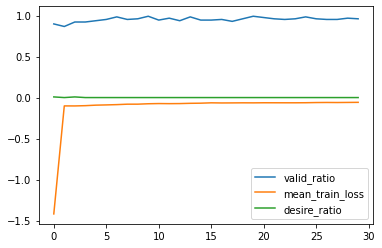

In [201]:
df_info[['valid_ratio', 'mean_train_loss', 'desire_ratio']].plot.line()

In [202]:
#save image
import matplotlib.pyplot as plt
plt.savefig("Images/Ratios")

<Figure size 432x288 with 0 Axes>

In [204]:
agent = RNN(voc, is_lstm=True, use_gpus=GPUS)
agent.loadStatesFromFile('drugex/models/finetuned/ligand_agent_rl.pkg')

smiles_rl = sample_smiles(agent, 1000)

In [205]:
scores = environment.getScores(smiles_rl)
scores

,PTP1B_CLS_MS,SA,DESIRE,VALID
0,0.0,0.948686,0,1
1,0.0,0.951061,0,1
2,0.0,0.961974,0,1
3,0.0,0.694951,0,1
4,0.0,0.938884,0,1
...,...,...,...,...
995,0.0,0.986762,0,1
996,0.0,0.071356,0,1
997,0.0,0.864072,0,1
998,0.0,0.966710,0,1


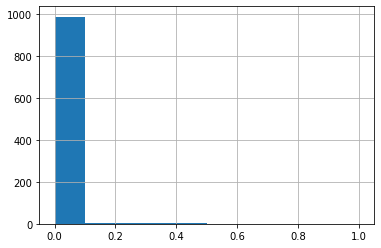

In [210]:
scores.PTP1B_CLS_MS.hist()

In [211]:
#save image
import matplotlib.pyplot as plt
plt.savefig("Images/PTP1B_CLS_MS")

<Figure size 432x288 with 0 Axes>

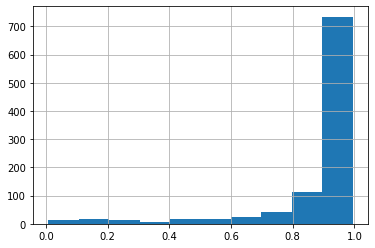

In [212]:
scores.SA.hist()

In [213]:
#save image
import matplotlib.pyplot as plt
plt.savefig("Images/new SA")

<Figure size 432x288 with 0 Axes>

In [214]:
dataset = DataSetSMILES("data/finetuned_rl_sampled.tsv", smiles=smiles_rl, use_existing=False)
dataset.addData('CLS', scores.PTP1B_CLS_MS)
dataset.addDescriptors([MorganFP(radius=2, nBits=1024)], recalculate=False) 

plt = Plot(dataset, TSNE())
plt.plot(
    recalculate=False,
    color_by='CLS',
    color_continuous_scale="rdylgn",
    color_style='continuous',
    viewport_height=800,
    port=9595
)

<IPython.core.display.Javascript object>

In [215]:
df_joined = pd.concat(
    [
        pd.DataFrame(
            {'SMILES' : df_ptp1b.SMILES.tolist(), 'Group': 'PTP1B Set'}
        ),
        pd.DataFrame(
            {'SMILES' : smiles_rl, 'Group': 'Generated'}
        )
    ]
)
df_joined

,SMILES,Group
0,CC(C)CC(CC(=O)C(Cc1ccc(OC(F)(F)C(=O)O)cc1)NC(=...,PTP1B Set
1,CC1(C)CCC2(C(=O)Nc3ccc(C(=O)O)cc3)CCC3(C)C(=CC...,PTP1B Set
2,CCOc1ccc(OC(=O)CSc2nnc(-c3cc(O)c(O)cc3)o2)cc1,PTP1B Set
3,CCCOc1ccc(-c2cccc(-c3noc(Cc4c[nH]c5ccccc45)n3)...,PTP1B Set
4,O=C(O)COc1ccc(S(=O)(=O)N(Cc2ccc(C(F)(F)P(=O)(O...,PTP1B Set
...,...,...
995,COC(=O)c1cc(-c2ccc(OC)cc2)on1,Generated
996,COc1ccccc1C1C(C(=O)C(C)(C)C)C(=O)C(=COC(C)=O)C...,Generated
997,CCOC(=O)c1ccc2[nH]c(C(=O)C(Cc3ccc(C(C)C)cc3)NC...,Generated
998,O=C(O)C(=O)Nc1cccc(-c2sc(C(=O)O)nc2-c2ccc(F)cc...,Generated


In [216]:
from scaffviz.data.dataset import DataSetTSV

dataset = DataSetTSV("data/original_and_generated.tsv", data=df_joined)
dataset.addDescriptors([MorganFP(radius=2, nBits=1024)], recalculate=False) 

plt = Plot(dataset, TSNE())
plt.plot(
    recalculate=False,
    color_by='Group',
    viewport_height=800,
    port=9696
)

<IPython.core.display.Javascript object>

In [217]:
# Load data
df = pd.read_table('data/original_and_generated.tsv')

In [218]:
df = df[df['Group']=="Generated"][['SMILES']]

,SMILES,ROMol
1772,O=C1Cc2cc(-c3ccc(-c4ccccc4)cc3)ccc2C1O,
1773,COCCC(C(=O)O)c1ccc(COCc2ccc(-c3ccc(OC)cc3)cc2)cc1,
1774,O=C(CCc1ccccc1)NC(Cc1ccc(-c2ccc(C(F)(F)F)cc2)c...,
1775,CCCS(=O)(=O)NC(CC=CCNC(=O)C(C)O)Oc1cccc2ccccc12,
1776,Cc1ccc(-c2cccc(COc3ccc(C(CC(=O)O)C4CC4)cc3)n2)cc1,
...,...,...
2767,COC(=O)c1cc(-c2ccc(OC)cc2)on1,
2768,COc1ccccc1C1C(C(=O)C(C)(C)C)C(=O)C(=COC(C)=O)C...,
2769,CCOC(=O)c1ccc2[nH]c(C(=O)C(Cc3ccc(C(C)C)cc3)NC...,
2770,O=C(O)C(=O)Nc1cccc(-c2sc(C(=O)O)nc2-c2ccc(F)cc...,

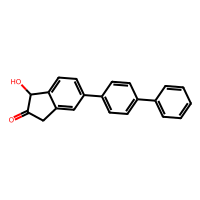
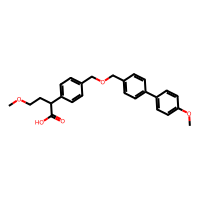
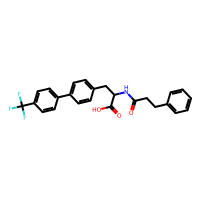
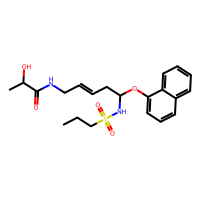
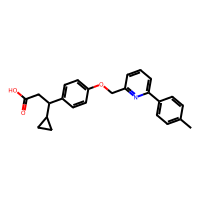
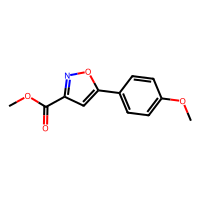
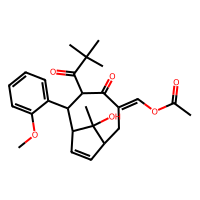
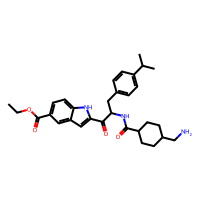
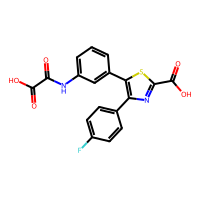
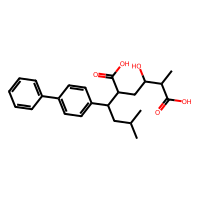

In [219]:
PandasTools.AddMoleculeColumnToFrame(df, "SMILES")
df

,SMILES,ROMol,molecular_weight,n_hba,n_hbd,logp
1772,O=C1Cc2cc(-c3ccc(-c4ccccc4)cc3)ccc2C1O,,300.115030,2,1,4.17920
1773,COCCC(C(=O)O)c1ccc(COCc2ccc(-c3ccc(OC)cc3)cc2)cc1,,420.193674,4,1,5.28370
1774,O=C(CCc1ccccc1)NC(Cc1ccc(-c2ccc(C(F)(F)F)cc2)c...,,441.155178,2,2,5.11710
1775,CCCS(=O)(=O)NC(CC=CCNC(=O)C(C)O)Oc1cccc2ccccc12,,420.171893,5,3,2.31740
1776,Cc1ccc(-c2cccc(COc3ccc(C(CC(=O)O)C4CC4)cc3)n2)cc1,,387.183444,3,1,5.60432
...,...,...,...,...,...,...
2767,COC(=O)c1cc(-c2ccc(OC)cc2)on1,,233.068808,5,0,2.13680
2768,COc1ccccc1C1C(C(=O)C(C)(C)C)C(=O)C(=COC(C)=O)C...,,440.219889,6,1,3.98320
2769,CCOC(=O)c1ccc2[nH]c(C(=O)C(Cc3ccc(C(C)C)cc3)NC...,,517.294057,5,3,5.14330
2770,O=C(O)C(=O)Nc1cccc(-c2sc(C(=O)O)nc2-c2ccc(F)cc...,,386.037271,5,3,3.33750

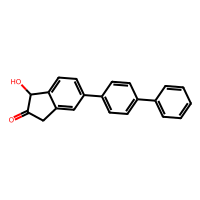
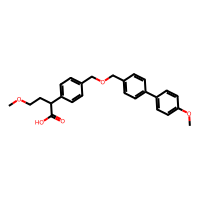
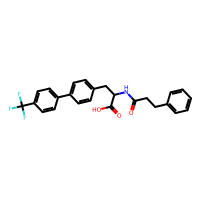
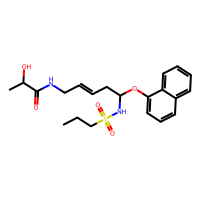
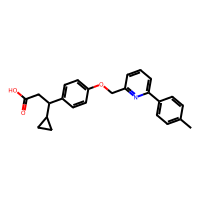
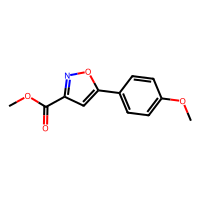
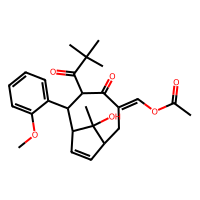
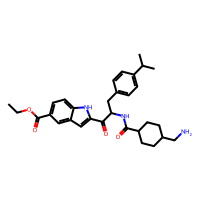
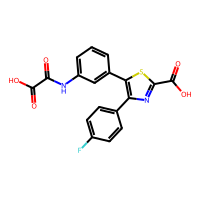
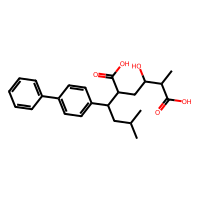

In [220]:
df["molecular_weight"] = df["ROMol"].apply(Descriptors.ExactMolWt)
df["n_hba"] = df["ROMol"].apply(Descriptors.NumHAcceptors)
df["n_hbd"] = df["ROMol"].apply(Descriptors.NumHDonors)
df["logp"] = df["ROMol"].apply(Descriptors.MolLogP)
# NBVAL_CHECK_OUTPUT
df

In [221]:
# Define Lipinski Rule
ro5_properties = {
    "molecular_weight": (500, "molecular weight (Da)"),
    "n_hba": (10, "# HBA"),
    "n_hbd": (5, "# HBD"),
    "logp": (5, "logP"),
}

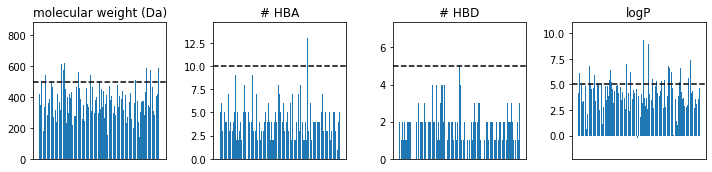

In [222]:
import matplotlib.pyplot as plt

# Start 1x4 plot frame
fig, axes = plt.subplots(figsize=(10, 2.5), nrows=1, ncols=4)
x = np.arange(1, len(df) + 1)

# Create subplots
for index, (key, (threshold, title)) in enumerate(ro5_properties.items()):
    axes[index].bar(df.index,df[key])
    axes[index].axhline(y=threshold, color="black", linestyle="dashed")
    axes[index].set_title(title)
    axes[index].set_xticks([])

# Fit subplots and legend into figure
plt.tight_layout()
plt.show()

In [223]:
#save image
import matplotlib.pyplot as plt
plt.savefig("Images/generated lipinskis")

<Figure size 432x288 with 0 Axes>

In [224]:
# This takes a couple of seconds
ro5_properties = df["SMILES"].apply(calculate_ro5_properties)
df = pd.concat([df, ro5_properties], axis=1)
df = df[df['ro5_fulfilled']]
df

,SMILES,ROMol,molecular_weight,n_hba,n_hbd,logp,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
1772,O=C1Cc2cc(-c3ccc(-c4ccccc4)cc3)ccc2C1O,<rdkit.Chem.rdchem.Mol object at 0x7fb0e36b90d0>,300.115030,2,1,4.17920,300.115030,2,1,4.17920,True
1773,COCCC(C(=O)O)c1ccc(COCc2ccc(-c3ccc(OC)cc3)cc2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7fb0e36b9080>,420.193674,4,1,5.28370,420.193674,4,1,5.28370,True
1774,O=C(CCc1ccccc1)NC(Cc1ccc(-c2ccc(C(F)(F)F)cc2)c...,<rdkit.Chem.rdchem.Mol object at 0x7fb0e36e6f80>,441.155178,2,2,5.11710,441.155178,2,2,5.11710,True
1775,CCCS(=O)(=O)NC(CC=CCNC(=O)C(C)O)Oc1cccc2ccccc12,<rdkit.Chem.rdchem.Mol object at 0x7fb0e36e6f30>,420.171893,5,3,2.31740,420.171893,5,3,2.31740,True
1776,Cc1ccc(-c2cccc(COc3ccc(C(CC(=O)O)C4CC4)cc3)n2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7fb0e36e6ee0>,387.183444,3,1,5.60432,387.183444,3,1,5.60432,True
...,...,...,...,...,...,...,...,...,...,...,...
2766,COc1ccc(C=C2SC(=O)N(Cc3ccc(C(=O)O)cc3)C2=O)cc1OC,<rdkit.Chem.rdchem.Mol object at 0x7fb0ea0dbda0>,399.077658,6,1,3.63850,399.077658,6,1,3.63850,True
2767,COC(=O)c1cc(-c2ccc(OC)cc2)on1,<rdkit.Chem.rdchem.Mol object at 0x7fb0ea0dbdf0>,233.068808,5,0,2.13680,233.068808,5,0,2.13680,True
2768,COc1ccccc1C1C(C(=O)C(C)(C)C)C(=O)C(=COC(C)=O)C...,<rdkit.Chem.rdchem.Mol object at 0x7fb0ea0dbe40>,440.219889,6,1,3.98320,440.219889,6,1,3.98320,True
2770,O=C(O)C(=O)Nc1cccc(-c2sc(C(=O)O)nc2-c2ccc(F)cc...,<rdkit.Chem.rdchem.Mol object at 0x7fb0ea0dbee0>,386.037271,5,3,3.33750,386.037271,5,3,3.33750,True


In [225]:
# Save dataset for next notebook
df.to_csv('PTP1B_generated_lipinski.csv')
df.head()

,SMILES,ROMol,molecular_weight,n_hba,n_hbd,logp,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
1772,O=C1Cc2cc(-c3ccc(-c4ccccc4)cc3)ccc2C1O,<rdkit.Chem.rdchem.Mol object at 0x7fb0e36b90d0>,300.115030,2,1,4.17920,300.115030,2,1,4.17920,True
1773,COCCC(C(=O)O)c1ccc(COCc2ccc(-c3ccc(OC)cc3)cc2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7fb0e36b9080>,420.193674,4,1,5.28370,420.193674,4,1,5.28370,True
1774,O=C(CCc1ccccc1)NC(Cc1ccc(-c2ccc(C(F)(F)F)cc2)c...,<rdkit.Chem.rdchem.Mol object at 0x7fb0e36e6f80>,441.155178,2,2,5.11710,441.155178,2,2,5.11710,True
1775,CCCS(=O)(=O)NC(CC=CCNC(=O)C(C)O)Oc1cccc2ccccc12,<rdkit.Chem.rdchem.Mol object at 0x7fb0e36e6f30>,420.171893,5,3,2.31740,420.171893,5,3,2.31740,True
1776,Cc1ccc(-c2cccc(COc3ccc(C(CC(=O)O)C4CC4)cc3)n2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7fb0e36e6ee0>,387.183444,3,1,5.60432,387.183444,3,1,5.60432,True


In [226]:
PTP1B_data = pd.read_csv("PTP1B_generated_lipinski.csv")
PTP1B_data = PTP1B_data.iloc[:,1:]

# Drop unnecessary information
print("Dataframe shape:", PTP1B_data.shape)
PTP1B_data.drop(columns=["molecular_weight.1", "n_hbd.1", "n_hba.1", "logp.1", "molecular_weight", "n_hbd", "n_hba", "logp"], inplace=True)
PTP1B_data.head()

Dataframe shape: (905, 11)


,SMILES,ROMol,ro5_fulfilled
0,O=C1Cc2cc(-c3ccc(-c4ccccc4)cc3)ccc2C1O,<rdkit.Chem.rdchem.Mol object at 0x7fb0e36b90d0>,True
1,COCCC(C(=O)O)c1ccc(COCc2ccc(-c3ccc(OC)cc3)cc2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7fb0e36b9080>,True
2,O=C(CCc1ccccc1)NC(Cc1ccc(-c2ccc(C(F)(F)F)cc2)c...,<rdkit.Chem.rdchem.Mol object at 0x7fb0e36e6f80>,True
3,CCCS(=O)(=O)NC(CC=CCNC(=O)C(C)O)Oc1cccc2ccccc12,<rdkit.Chem.rdchem.Mol object at 0x7fb0e36e6f30>,True
4,Cc1ccc(-c2cccc(COc3ccc(C(CC(=O)O)C4CC4)cc3)n2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7fb0e36e6ee0>,True


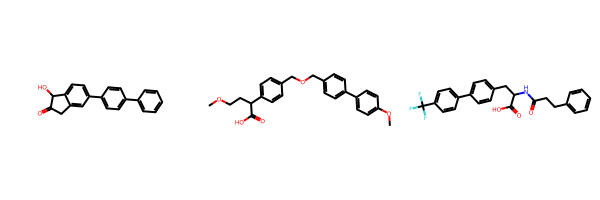

In [227]:
# Add molecule column
PandasTools.AddMoleculeColumnToFrame(PTP1B_data, smilesCol="SMILES")
# Draw first 3 molecules
Chem.Draw.MolsToGridImage(
    list(PTP1B_data.head(3).ROMol)
)

In [228]:
from pathlib import Path

from tqdm.auto import tqdm
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams

In [229]:
# initialize filter
params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
catalog = FilterCatalog(params)

In [230]:
# search for PAINS
matches = []
clean = []
for index, row in tqdm(PTP1B_data.iterrows(), total=PTP1B_data.shape[0]):
    molecule = Chem.MolFromSmiles(row.SMILES)
    entry = catalog.GetFirstMatch(molecule)  # Get the first matching PAINS
    if entry is not None:
        # store PAINS information
        matches.append(
            {
                "chembl_id": row.SMILES,
                "rdkit_molecule": molecule,
                "pains": entry.GetDescription().capitalize(),
            }
        )
    else:
        # collect indices of molecules without PAINS
        clean.append(index)

matches = pd.DataFrame(matches)
PTP1B_data = PTP1B_data.loc[clean]  # keep molecules without PAINS

  0%|          | 0/905 [00:00<?, ?it/s]

In [231]:
# NBVAL_CHECK_OUTPUT
print(f"Number of compounds with PAINS: {len(matches)}")
print(f"Number of compounds without PAINS: {len(PTP1B_data)}")

PTP1B_data.to_csv("PAINS_removed_generated.csv")

Number of compounds with PAINS: 61
Number of compounds without PAINS: 844


In [234]:
g = open("Pains.txt",'a')
print(f"Number of compounds with PAINS: {len(matches)}",file = g)
print(f"Number of compounds without PAINS: {len(PTP1B_data)}",file = g)

In [235]:
substructures = pd.read_csv("unwanted_substructures.csv", sep="\s+")
substructures["rdkit_molecule"] = substructures.smarts.apply(Chem.MolFromSmarts)
print("Number of unwanted substructures in collection:", len(substructures))
# NBVAL_CHECK_OUTPUT

Number of unwanted substructures in collection: 104


In [236]:
h = open("Unwanted generated.txt",'a')
print("Number of unwanted substructures in collection:", len(substructures),file = g)

In [237]:
# search for unwanted substructure
matches = []
clean = []
for index, row in tqdm(PTP1B_data.iterrows(), total=PTP1B_data.shape[0]):
    molecule = Chem.MolFromSmiles(row.SMILES)
    match = False
    for _, substructure in substructures.iterrows():
        if molecule.HasSubstructMatch(substructure.rdkit_molecule):
            matches.append(
                {
                    "chembl_id": row.SMILES,
                    "rdkit_molecule": molecule,
                    "substructure": substructure.rdkit_molecule,
                    "substructure_name": substructure["name"],
                }
            )
            match = True
    if not match:
        clean.append(index)

matches = pd.DataFrame(matches)
PTP1B_data = PTP1B_data.loc[clean]

  0%|          | 0/844 [00:00<?, ?it/s]

In [238]:
# NBVAL_CHECK_OUTPUT
print(f"Number of found unwanted substructure: {len(matches)}")
print(f"Number of compounds without unwanted substructure: {len(PTP1B_data)}")

Number of found unwanted substructure: 563
Number of compounds without unwanted substructure: 451


In [239]:
j = open("Ratio unwanted structures.txt","a")
print(f"Number of found unwanted substructure: {len(matches)}",file = j)
print(f"Number of compounds without unwanted substructure: {len(PTP1B_data)}", file = j)

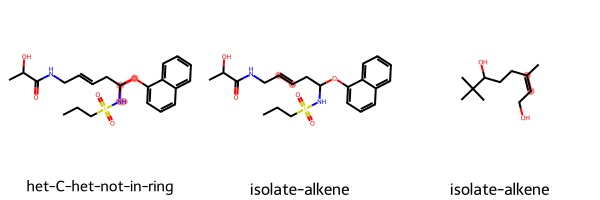

In [240]:
to_highlight = [
    row.rdkit_molecule.GetSubstructMatch(row.substructure) for _, row in matches.head(3).iterrows()
]
Chem.Draw.MolsToGridImage(
    list(matches.head(3).rdkit_molecule),
    highlightAtomLists=to_highlight,
    legends=list(matches.head(3).substructure_name),
)

In [241]:
PTP1B_data.to_csv("PAINSandUNWANTED_removed_generated.csv")
PTP1B_data

,SMILES,ROMol,ro5_fulfilled
0,O=C1Cc2cc(-c3ccc(-c4ccccc4)cc3)ccc2C1O,<rdkit.Chem.rdchem.Mol object at 0x7fb25e50ac10>,True
1,COCCC(C(=O)O)c1ccc(COCc2ccc(-c3ccc(OC)cc3)cc2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7fb25e50a8f0>,True
2,O=C(CCc1ccccc1)NC(Cc1ccc(-c2ccc(C(F)(F)F)cc2)c...,<rdkit.Chem.rdchem.Mol object at 0x7fb25e50ada0>,True
4,Cc1ccc(-c2cccc(COc3ccc(C(CC(=O)O)C4CC4)cc3)n2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7fb25e5307b0>,True
7,O=C(O)c1ccc2c(c1)CN(c1ccc(-c3cc(-c4ccsc4)ccc3N...,<rdkit.Chem.rdchem.Mol object at 0x7fb25faa6f80>,True
...,...,...,...
896,COc1ccccc1CNC(=O)C1(C)CCN1C(=O)c1cc(C(F)(F)F)c...,<rdkit.Chem.rdchem.Mol object at 0x7fb25fa23c10>,True
898,O=C(O)C(Cc1ccccc1)N1CC(=O)N(CCc2ccccc2)C(Cc2cc...,<rdkit.Chem.rdchem.Mol object at 0x7fb25fa23800>,True
899,CC1(C)CCC(Oc2ccc(-c3ccc(C(=O)Nc4cccnc4)cc3)n2C...,<rdkit.Chem.rdchem.Mol object at 0x7fb25fa23210>,True
901,COC(=O)c1cc(-c2ccc(OC)cc2)on1,<rdkit.Chem.rdchem.Mol object at 0x7fb25fa236c0>,True


In [242]:
data = pd.read_csv("PAINSandUNWANTED_removed_generated.csv")

In [243]:
data['fp'] = data['SMILES'].apply(smiles_to_fp)

In [244]:
#Load ML model
model = keras.models.load_model('Activity_prediction.h5')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 167)]             0         
                                                                 
 dense (Dense)               (None, 32)                5376      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6,465
Trainable params: 6,465
Non-trainable params: 0
_________________________________________________________________


In [245]:
Activity = []
for i in range(len(data)):
    Activity.append(model(np.expand_dims(data['fp'][i], axis=0)).numpy()[0][0])

In [246]:
Activity

[8.816177e-07,
 2.9041358e-14,
 9.937551e-10,
 5.9361354e-13,
 4.676217e-05,
 3.648635e-08,
 1.0009959e-06,
 9.870123e-12,
 8.805194e-09,
 4.2123133e-07,
 6.5334507e-09,
 3.889202e-11,
 3.4877414e-06,
 1.03570855e-07,
 0.0016655806,
 5.6864997e-07,
 2.1410984e-05,
 3.1125956e-07,
 2.1492341e-12,
 5.716002e-07,
 3.2381504e-09,
 6.9409034e-06,
 1.0091278e-06,
 0.0069948044,
 0.015083512,
 6.535255e-05,
 7.149883e-08,
 1.85018e-05,
 9.94726e-10,
 7.8980567e-10,
 3.92271e-08,
 1.6766595e-08,
 1.8348362e-10,
 1.7105481e-06,
 0.7507025,
 1.3460567e-07,
 1.9172833e-06,
 3.6041824e-06,
 1.2833657e-09,
 6.740295e-05,
 3.3755404e-07,
 2.921086e-10,
 9.729507e-06,
 2.9763592e-10,
 7.724027e-12,
 1.2406175e-10,
 0.7407312,
 4.6303413e-08,
 1.8826801e-11,
 3.228769e-07,
 9.497424e-11,
 7.6177653e-06,
 2.0877831e-08,
 4.3410076e-09,
 7.316517e-09,
 0.023510143,
 0.00015387974,
 1.6543805e-05,
 8.495305e-14,
 5.0161972e-09,
 1.388059e-05,
 7.999091e-05,
 4.5097915e-14,
 3.6684256e-07,
 0.008829197,
 

In [247]:
data['activity'] = Activity

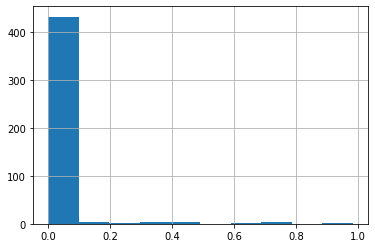

In [248]:
data['activity'].hist()

In [249]:
active = data[data['activity']>0.5]

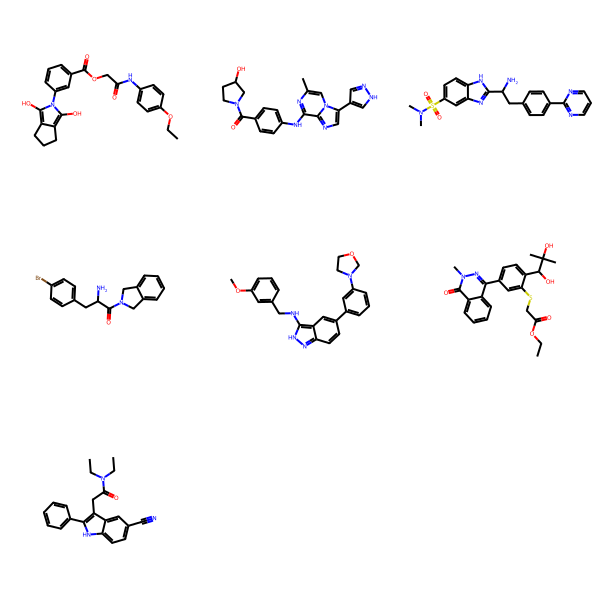

In [250]:
# Add molecule column
PandasTools.AddMoleculeColumnToFrame(active, smilesCol="SMILES")
# Draw first 3 molecules
Chem.Draw.MolsToGridImage(
    list(active.ROMol)
)

In [251]:
df = pd.read_csv("PAINSandUNWANTED_removed_generated.csv")
df

,Unnamed: 0,SMILES,ROMol,ro5_fulfilled
0,0,O=C1Cc2cc(-c3ccc(-c4ccccc4)cc3)ccc2C1O,<rdkit.Chem.rdchem.Mol object at 0x7fb25e50ac10>,True
1,1,COCCC(C(=O)O)c1ccc(COCc2ccc(-c3ccc(OC)cc3)cc2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7fb25e50a8f0>,True
2,2,O=C(CCc1ccccc1)NC(Cc1ccc(-c2ccc(C(F)(F)F)cc2)c...,<rdkit.Chem.rdchem.Mol object at 0x7fb25e50ada0>,True
3,4,Cc1ccc(-c2cccc(COc3ccc(C(CC(=O)O)C4CC4)cc3)n2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7fb25e5307b0>,True
4,7,O=C(O)c1ccc2c(c1)CN(c1ccc(-c3cc(-c4ccsc4)ccc3N...,<rdkit.Chem.rdchem.Mol object at 0x7fb25faa6f80>,True
...,...,...,...,...
446,896,COc1ccccc1CNC(=O)C1(C)CCN1C(=O)c1cc(C(F)(F)F)c...,<rdkit.Chem.rdchem.Mol object at 0x7fb25fa23c10>,True
447,898,O=C(O)C(Cc1ccccc1)N1CC(=O)N(CCc2ccccc2)C(Cc2cc...,<rdkit.Chem.rdchem.Mol object at 0x7fb25fa23800>,True
448,899,CC1(C)CCC(Oc2ccc(-c3ccc(C(=O)Nc4cccnc4)cc3)n2C...,<rdkit.Chem.rdchem.Mol object at 0x7fb25fa23210>,True
449,901,COC(=O)c1cc(-c2ccc(OC)cc2)on1,<rdkit.Chem.rdchem.Mol object at 0x7fb25fa236c0>,True


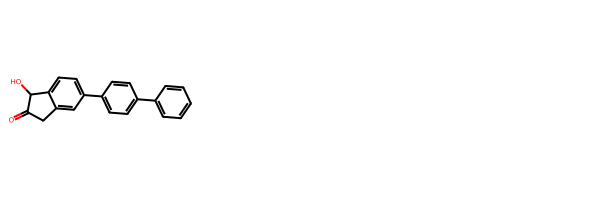

In [252]:
# Add molecule column
PandasTools.AddMoleculeColumnToFrame(df, smilesCol="SMILES")
Chem.Draw.MolsToGridImage(
    df.iloc[:1].ROMol
)

In [253]:
active.to_csv('Active_generated_molecules.csv')

In [260]:
os.chdir("..")

In [261]:
## This code block imports python modules to work with during the lab, you need to run it first to get started.
# modules
!pip install nglview
!pip install Bio
!pip install rdkit

import scripts
import nglview
import os
import shutil
from Bio.PDB import PDBParser, PDBIO, Select,  PDBList, MMCIFParser, StructureAlignment
import Bio.Align
import os
from pathlib import Path
import rdkit

from scripts import viewer
from scripts import bio_align

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [264]:
from google.colab import output
output.enable_custom_widget_manager()

In [265]:

import nglview
view = nglview.show_pdbid(TARGET_PDB_ID)
view

NGLWidget()

In [266]:
view.center(LIGAND_CODE)
view

NGLWidget()

In [267]:
viewer.show_residues_around(view, selection=LIGAND_CODE)
view

NGLWidget(n_components=1)

In [274]:
pdbl = PDBList()
pdbl.retrieve_pdb_file(TARGET_PDB_ID, pdir=TARGET_PDB_ID)

'2qbs/2qbs.cif'

In [275]:
parser = MMCIFParser()
structure = parser.get_structure("TARGETPROT",'{}/{}.cif'.format(TARGET_PDB_ID,TARGET_PDB_ID))

In [278]:
class ResSelect(Select):
    def accept_residue(self, residue):
        if residue.get_resname() == LIGAND_CODE:
            return 1
        else:
            return 0

class NonHetSelect(Select):
    def accept_residue(self, residue):
        return 1 if residue.id[0] == " " else 0

io = PDBIO()
io.set_structure(structure)
io.save("Ligands/ligand-{}.pdb".format(LIGAND_CODE), ResSelect())
io.save("Proteins/protein-{}.pdb".format(TARGET_PDB_ID), NonHetSelect())

In [279]:
from google.colab import output
output.enable_custom_widget_manager()

In [281]:
command = 'lepro protein-{}.pdb'.format(TARGET_PDB_ID)
os.system(command)

shutil.move('Proteins/protein-{}.pdb'.format(TARGET_PDB_ID),'Prepped/{}_prepped.pdb'.format(TARGET_PDB_ID))

'Prepped/2qbs_prepped.pdb'

In [282]:
# combine protein and ligand files
filenames = [
'Prepped/{}_prepped.pdb'.format(TARGET_PDB_ID),
"Ligands/ligand-{}.pdb".format(LIGAND_CODE)
]
with open('Complexes/{}-complex.pdb'.format(TARGET_PDB_ID), 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                if not "END" in line:
                    outfile.write(line)

In [283]:
with open('Complexes/{}-complex.pdb'.format(TARGET_PDB_ID)) as f:
    view = nglview.show_file(f, ext="pdb")
    
view.center(LIGAND_CODE)
viewer.show_residues_around(view, selection=LIGAND_CODE)
view

NGLWidget()

In [285]:


pdbl = PDBList()
pdbl.retrieve_pdb_file(OFF_TARGET_PDB_ID, pdir=OFF_TARGET_PDB_ID)

parser = MMCIFParser()
structure = parser.get_structure("TARGETPROT",'{}/{}.cif'.format(OFF_TARGET_PDB_ID,OFF_TARGET_PDB_ID))

class ResSelect(Select):
    def accept_residue(self, residue):
        if residue.get_resname() == OFF_TARGET_LIGAND:
            return 1
        else:
            return 0

io = PDBIO()
io.set_structure(structure)
io.save("Ligands/ligand-{}.pdb".format(OFF_TARGET_LIGAND), ResSelect())
io.save("Proteins/protein-{}.pdb".format(OFF_TARGET_PDB_ID), NonHetSelect())

Structure exists: '2qbq/2qbq.cif' 


In [287]:
command = 'lepro protein-{}.pdb'.format(OFF_TARGET_PDB_ID)
os.system(command)
shutil.move('Proteins/protein-{}.pdb'.format(OFF_TARGET_PDB_ID),'Prepped/{}_prepped.pdb'.format(OFF_TARGET_PDB_ID))

'Prepped/2qbq_prepped.pdb'

In [288]:
# combine protein and ligand files
filenames = [
'Prepped/{}_prepped.pdb'.format(OFF_TARGET_PDB_ID),
"Ligands/ligand-{}.pdb".format(OFF_TARGET_LIGAND)
]
with open('Complexes/{}-complex.pdb'.format(OFF_TARGET_PDB_ID), 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                if not "END" in line:
                    outfile.write(line)

In [289]:
with open('Complexes/{}-complex.pdb'.format(OFF_TARGET_PDB_ID)) as f:
    view = nglview.show_file(f, ext="pdb")
    
view.center(OFF_TARGET_LIGAND)
viewer.show_residues_around(view, selection=OFF_TARGET_LIGAND)
view

NGLWidget()

In [290]:
from Bio import pairwise2
from Bio.Seq import Seq 
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment



import requests
data = requests.get(f'https://www.ebi.ac.uk/pdbe/api/pdb/entry/molecules/{PDBCODE_1}').json()[PDBCODE_1.lower()]
SEQ1 = (data[0]['sequence'])
SEQ1 = Seq(SEQ1)

data = requests.get(f'https://www.ebi.ac.uk/pdbe/api/pdb/entry/molecules/{PDBCODE_2}').json()[PDBCODE_2.lower()]
SEQ2 = (data[0]['sequence'])
SEQ2 = Seq(SEQ2)

alignments = pairwise2.align.globalxx(SEQ1, SEQ2)

for align1, align2, score, begin, end in alignments:
    filename = "alignment.fasta"
    with open(filename, "w") as handle:
        handle.write(">SEQ1\n%s\n>SEQ2\n%s\n" % (align1, align2))

print(alignments[0])

Alignment(seqA='MEMEKEFEQIDKSGSWAAIYQDIRHEASDFPCRVAKLPKNKNRNRYRDVSPFDHSRIKLHQEDNDYINASLIKMEEAQRSYILTQGPLPNTCGHFWEMVWEQKSRGVVMLNRVMEKGSLKCAQYWPQKEEKEMIFEDTNLKLTLISEDIKSYYTVRQLELENLTTQETREILHFHYTTWPDFGVPESPASFLNFLFKVRESGSLSPEHGPVVVHCSAGIGRSGTFCLADTCLLLMDKRKDPSSVDIKKVLLEMRKFRMGLIQTADQLRFSYLAVIEGAKFIMGDSSVQDQWKELSHEDL', seqB='MEMEKEFEQIDKSGSWAAIYQDIRHEASDFPCRVAKLPKNKNRNRYRDVSPFDHSRIKLHQEDNDYINASLIKMEEAQRSYILTQGPLPNTCGHFWEMVWEQKSRGVVMLNRVMEKGSLKCAQYWPQKEEKEMIFEDTNLKLTLISEDIKSYYTVRQLELENLTTQETREILHFHYTTWPDFGVPESPASFLNFLFKVRESGSLSPEHGPVVVHCSAGIGRSGTFCLADTCLLLMDKRKDPSSVDIKKVLLEMRKFRMGLIQTADQLRFSYLAVIEGAKFIMGDSSVQDQWKELSHEDL', score=299.0, start=0, end=299)


In [291]:
bio_align.run('Complexes/{}-complex.pdb'.format(TARGET_PDB_ID),'Complexes/{}-complex.pdb'.format(OFF_TARGET_PDB_ID))

In [294]:
# combine protein and ligand files
filenames = [
'Complexes/{}-complex.pdb'.format(TARGET_PDB_ID,TARGET_PDB_ID),
"{}-complex_transformed.pdb".format(OFF_TARGET_PDB_ID)
]
with open('{}-{}-merged.pdb'.format(TARGET_PDB_ID,OFF_TARGET_PDB_ID), 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                if not "END" in line:
                    outfile.write(line)
                    
with open('{}-{}-merged.pdb'.format(TARGET_PDB_ID,OFF_TARGET_PDB_ID)) as f:
    view = nglview.show_file(f, ext="pdb")
    
view

NGLWidget()

In [295]:
#from pymol import cmd
import py3Dmol

import pandas as pd
import glob
import sys

from vina import Vina
#import pybel

from rdkit import Chem
from rdkit.Chem import AllChem, Draw

#from meeko import MoleculePreparation
#from meeko import obutils

import MDAnalysis as mda
from MDAnalysis.coordinates import PDB

#import prolif
#from prolif.plotting.network import LigNetwork

import nglview
#from scripts import viewer

import sys, os, shutil
#sys.path.insert(1, '/project/jhllei001/JHL_data/Jupyter_Dock/utilities')
# Note I had to comment out pymol, openmm and pdbfixer, hope it doesn't break later
#from utils import fix_protein, getbox, generate_ledock_file, pdbqt_to_sdf, dok_to_sdf

import warnings
warnings.filterwarnings("ignore")
%config Completer.use_jedi = False

In [296]:
os.getcwd()


'/content/drive/MyDrive/ACMDD/DeNovo'

In [297]:
try:
    os.mkdir('Docking')
except:
    print("Directory already exists")
os.chdir('Docking')


In [298]:
os.chdir("..")

In [299]:
active_de_novo = pd.read_csv("data/Active_generated_molecules.csv")
test_smiles = active_de_novo['SMILES'].values
active_de_novo

,Unnamed: 0,Unnamed: 0.1,SMILES,ROMol,ro5_fulfilled,fp,activity
0,34,70,CCOc1ccc(NC(=O)COC(=O)c2cccc(-n3c(O)c4c(c3O)CC...,<rdkit.Chem.rdchem.Mol object at 0x7fb25fbb8580>,True,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,0.750703
1,46,88,Cc1cn2c(-c3cn[nH]c3)cnc2c(Nc2ccc(C(=O)N3CCC(O)...,<rdkit.Chem.rdchem.Mol object at 0x7fb25fbb83a0>,True,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,0.740731
2,172,337,CN(C)S(=O)(=O)c1ccc2[nH]c(C(N)Cc3ccc(-c4ncccn4...,<rdkit.Chem.rdchem.Mol object at 0x7fb25fbb84e0>,True,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,0.672303
3,181,352,NC(Cc1ccc(Br)cc1)C(=O)N1Cc2ccccc2C1,<rdkit.Chem.rdchem.Mol object at 0x7fb25fbb8d50>,True,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,0.784637
4,210,425,COc1cccc(CNc2[nH]nc3ccc(-c4cccc(N5CCOC5)c4)cc2...,<rdkit.Chem.rdchem.Mol object at 0x7fb25fbb8350>,True,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,0.746750
5,350,703,CCOC(=O)CSc1cc(-c2nn(C)c(=O)c3ccccc23)ccc1C(O)...,<rdkit.Chem.rdchem.Mol object at 0x7fb25fbb8c10>,True,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,0.983144
6,403,822,CCN(CC)C(=O)Cc1c(-c2ccccc2)[nH]c2ccc(C#N)cc12,<rdkit.Chem.rdchem.Mol object at 0x7fb25fbb82b0>,True,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,0.610911


In [ ]:
os.chdir('Docking')

In [300]:
test_smiles

array(['CCOc1ccc(NC(=O)COC(=O)c2cccc(-n3c(O)c4c(c3O)CCC4)c2)cc1',
       'Cc1cn2c(-c3cn[nH]c3)cnc2c(Nc2ccc(C(=O)N3CCC(O)C3)cc2)n1',
       'CN(C)S(=O)(=O)c1ccc2[nH]c(C(N)Cc3ccc(-c4ncccn4)cc3)nc2c1',
       'NC(Cc1ccc(Br)cc1)C(=O)N1Cc2ccccc2C1',
       'COc1cccc(CNc2[nH]nc3ccc(-c4cccc(N5CCOC5)c4)cc23)c1',
       'CCOC(=O)CSc1cc(-c2nn(C)c(=O)c3ccccc23)ccc1C(O)C(C)(C)O',
       'CCN(CC)C(=O)Cc1c(-c2ccccc2)[nH]c2ccc(C#N)cc12'], dtype=object)

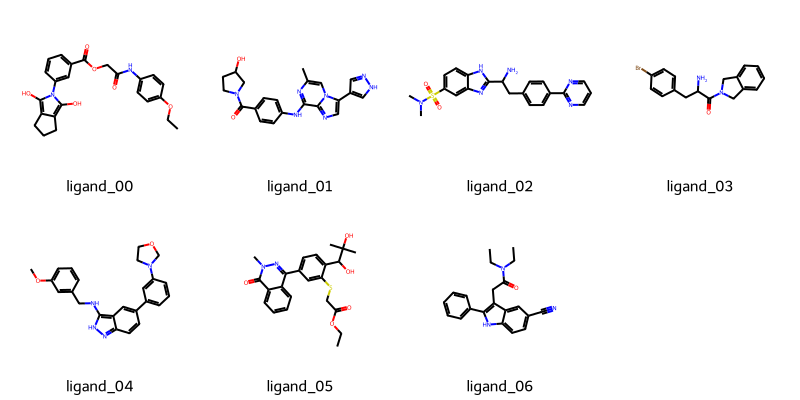

In [301]:
i = -1

IDs = []
for i in range(0,len(test_smiles)):
    base = 'ligand_{:02d}'.format(i)
    IDs.append(base)
    
df = pd.DataFrame({'ID':IDs, 'SMILES':test_smiles})

df['rdkit_mol'] = [Chem.MolFromSmiles(s) for s in df['SMILES']]

# Generate 2D images of the molecules
img=Draw.MolsToGridImage(df['rdkit_mol'].tolist(),
                            molsPerRow=4,
                            subImgSize=(200,200),
                            legends=df['ID'].tolist())

for i in range(len(df)):
    row = df.iloc[i]
    mol = row['rdkit_mol']
    name = row['ID'] + '.mol'
    Chem.MolToMolFile(mol,name)

img

In [305]:
#from pymol import cmd
import py3Dmol

import pandas as pd
import glob
import sys

from vina import Vina
#import pybel

from rdkit import Chem
from rdkit.Chem import AllChem, Draw

#from meeko import MoleculePreparation
#from meeko import obutils

import MDAnalysis as mda
from MDAnalysis.coordinates import PDB

#import prolif
#from prolif.plotting.network import LigNetwork

import nglview
#from scripts import viewer

import sys, os, shutil
#sys.path.insert(1, '/project/jhllei001/JHL_data/Jupyter_Dock/utilities')
# Note I had to comment out pymol, openmm and pdbfixer, hope it doesn't break later
#from utils import fix_protein, getbox, generate_ledock_file, pdbqt_to_sdf, dok_to_sdf

import warnings
warnings.filterwarnings("ignore")
%config Completer.use_jedi = False

In [307]:
class ResSelect(Select):
    def accept_residue(self, residue):
        if residue.get_resname() == LIGAND_CODE:
            return 1
        else:
            return 0

class NonHetSelect(Select):
    def accept_residue(self, residue):
        return 1 if residue.id[0] == " " else 0

io = PDBIO()
io.set_structure(structure)
io.save("Ligands/ligand-{}.pdb".format(LIGAND_CODE), ResSelect())
io.save("Proteins/protein-{}.pdb".format(TARGET_PDB_ID), NonHetSelect())

In [311]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('Proteins/protein-{}.pdb'.format(PDBCODE),'r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})


view.addModel(open('ligand_00.mol','r').read(),format='mol2')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.2}})

ligtmp = 'ligand-{}.pdb'.format(LIGAND_CODE)
view.addModelsAsFrames(open(ligtmp,'r').read(),format='pdb')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'magentaCarbon','radius':0.2}})

view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [312]:
from math import isnan, isinf
def PDBQTAtomLines(mol, donors, acceptors):
    """Create a list with PDBQT atom lines for each atom in molecule. Donors
    and acceptors are given as a list of atom indices.
    """

    atom_lines = [line.replace('HETATM', 'ATOM  ')
                  for line in Chem.MolToPDBBlock(mol).split('\n')
                  if line.startswith('HETATM') or line.startswith('ATOM')]

    pdbqt_lines = []
    for idx, atom in enumerate(mol.GetAtoms()):
        pdbqt_line = atom_lines[idx][:56]

        pdbqt_line += '0.00  0.00    '  # append empty vdW and ele
        # Get charge
        charge = 0.
        fields = ['_MMFF94Charge', '_GasteigerCharge', '_TriposPartialCharge']
        for f in fields:
            if atom.HasProp(f):
                charge = atom.GetDoubleProp(f)
                break
        # FIXME: this should not happen, blame RDKit
        if isnan(charge) or isinf(charge):
            charge = 0.
        pdbqt_line += ('%.3f' % charge).rjust(6)

        # Get atom type
        pdbqt_line += ' '
        atomicnum = atom.GetAtomicNum()
        if atomicnum == 6 and atom.GetIsAromatic():
            pdbqt_line += 'A'
        elif atomicnum == 7 and idx in acceptors:
            pdbqt_line += 'NA'
        elif atomicnum == 8 and idx in acceptors:
            pdbqt_line += 'OA'
        elif atomicnum == 1 and atom.GetNeighbors()[0].GetIdx() in donors:
            pdbqt_line += 'HD'
        else:
            pdbqt_line += atom.GetSymbol()
        pdbqt_lines.append(pdbqt_line)
    return pdbqt_lines

def MolToPDBQTBlock(mol, flexible=True, addHs=False, computeCharges=False):
    """Write RDKit Molecule to a PDBQT block

    Parameters
    ----------
        mol: rdkit.Chem.rdchem.Mol
            Molecule with a protein ligand complex
        flexible: bool (default=True)
            Should the molecule encode torsions. Ligands should be flexible,
            proteins in turn can be rigid.
        addHs: bool (default=False)
            The PDBQT format requires at least polar Hs on donors. By default Hs
            are added.
        computeCharges: bool (default=False)
            Should the partial charges be automatically computed. If the Hs are
            added the charges must and will be recomputed. If there are no
            partial charge information, they are set to 0.0.

    Returns
    -------
        block: str
            String wit PDBQT encoded molecule
    """
    # make a copy of molecule
    mol = Chem.Mol(mol)

    # if flexible molecule contains multiple fragments write them separately
    if flexible and len(Chem.GetMolFrags(mol)) > 1:
        return ''.join(MolToPDBQTBlock(frag, flexible=flexible, addHs=addHs,
                                       computeCharges=computeCharges)
                       for frag in Chem.GetMolFrags(mol, asMols=True))

    # Identify donors and acceptors for atom typing
    # Acceptors
    patt = Chem.MolFromSmarts('[$([O;H1;v2]),'
                              '$([O;H0;v2;!$(O=N-*),'
                              '$([O;-;!$(*-N=O)]),'
                              '$([o;+0])]),'
                              '$([n;+0;!X3;!$([n;H1](cc)cc),'
                              '$([$([N;H0]#[C&v4])]),'
                              '$([N&v3;H0;$(Nc)])]),'
                              '$([F;$(F-[#6]);!$(FC[F,Cl,Br,I])])]')
    acceptors = list(map(lambda x: x[0],
                         mol.GetSubstructMatches(patt, maxMatches=mol.GetNumAtoms())))
    # Donors
    patt = Chem.MolFromSmarts('[$([N&!H0&v3,N&!H0&+1&v4,n&H1&+0,$([$([Nv3](-C)(-C)-C)]),'
                              '$([$(n[n;H1]),'
                              '$(nc[n;H1])])]),'
                              # Guanidine can be tautormeic - e.g. Arginine
                              '$([NX3,NX2]([!O,!S])!@C(!@[NX3,NX2]([!O,!S]))!@[NX3,NX2]([!O,!S])),'
                              '$([O,S;H1;+0])]')
    donors = list(map(lambda x: x[0],
                      mol.GetSubstructMatches(patt, maxMatches=mol.GetNumAtoms())))
    if addHs:
        mol = Chem.AddHs(mol, addCoords=True, onlyOnAtoms=donors, )
    if addHs or computeCharges:
        AllChem.ComputeGasteigerCharges(mol)

    atom_lines = PDBQTAtomLines(mol, donors, acceptors)
    assert len(atom_lines) == mol.GetNumAtoms()

    pdbqt_lines = []

    # vina scores
    if (mol.HasProp('vina_affinity') and mol.HasProp('vina_rmsd_lb') and
            mol.HasProp('vina_rmsd_lb')):
        pdbqt_lines.append('REMARK VINA RESULT:  ' +
                           ('%.1f' % float(mol.GetProp('vina_affinity'))).rjust(8) +
                           ('%.3f' % float(mol.GetProp('vina_rmsd_lb'))).rjust(11) +
                           ('%.3f' % float(mol.GetProp('vina_rmsd_ub'))).rjust(11))

    pdbqt_lines.append('REMARK  Name = ' +
                       (mol.GetProp('_Name') if mol.HasProp('_Name') else ''))
    if flexible:
        # Find rotatable bonds
        rot_bond = Chem.MolFromSmarts('[!$(*#*)&!D1&!$(C(F)(F)F)&'
                                      '!$(C(Cl)(Cl)Cl)&'
                                      '!$(C(Br)(Br)Br)&'
                                      '!$(C([CH3])([CH3])[CH3])&'
                                      '!$([CD3](=[N,O,S])-!@[#7,O,S!D1])&'
                                      '!$([#7,O,S!D1]-!@[CD3]=[N,O,S])&'
                                      '!$([CD3](=[N+])-!@[#7!D1])&'
                                      '!$([#7!D1]-!@[CD3]=[N+])]-!@[!$(*#*)&'
                                      '!D1&!$(C(F)(F)F)&'
                                      '!$(C(Cl)(Cl)Cl)&'
                                      '!$(C(Br)(Br)Br)&'
                                      '!$(C([CH3])([CH3])[CH3])]')
        bond_atoms = list(mol.GetSubstructMatches(rot_bond))
        num_torsions = len(bond_atoms)

        # Active torsions header
        pdbqt_lines.append('REMARK  %i active torsions:' % num_torsions)
        pdbqt_lines.append('REMARK  status: (\'A\' for Active; \'I\' for Inactive)')
        for i, (a1, a2) in enumerate(bond_atoms):
            pdbqt_lines.append('REMARK%5.0i  A    between atoms: _%i  and  _%i'
                               % (i + 1, a1 + 1, a2 + 1))

        # Fragment molecule on bonds to ge rigid fragments
        bond_ids = [mol.GetBondBetweenAtoms(a1, a2).GetIdx()
                    for a1, a2 in bond_atoms]
        if bond_ids:
            mol_rigid_frags = Chem.FragmentOnBonds(mol, bond_ids, addDummies=False)
        else:
            mol_rigid_frags = mol
        frags = list(Chem.GetMolFrags(mol_rigid_frags))

        def weigh_frags(frag):
            """sort by the fragment size and the number of bonds (secondary)"""
            num_bonds = 0
            # bond_weight = 0
            for a1, a2 in bond_atoms:
                if a1 in frag or a2 in frag:
                    num_bonds += 1
                    # for frag2 in frags:
                    #     if a1 in frag2 or a2 in frag2:
                    #         bond_weight += len(frag2)

            # changed signs are fixing mixed sorting type (ascending/descending)
            return -len(frag), -num_bonds,  # bond_weight
        frags = sorted(frags, key=weigh_frags)

        # Start writting the lines with ROOT
        pdbqt_lines.append('ROOT')
        frag = frags.pop(0)
        for idx in frag:
            pdbqt_lines.append(atom_lines[idx])
        pdbqt_lines.append('ENDROOT')

        # Now build the tree of torsions usign DFS algorithm. Keep track of last
        # route with following variables to move down the tree and close branches
        branch_queue = []
        current_root = frag
        old_roots = [frag]

        visited_frags = []
        visited_bonds = []
        while len(frags) > len(visited_frags):
            end_branch = True
            for frag_num, frag in enumerate(frags):
                for bond_num, (a1, a2) in enumerate(bond_atoms):
                    if (frag_num not in visited_frags and
                        bond_num not in visited_bonds and
                        (a1 in current_root and a2 in frag or
                         a2 in current_root and a1 in frag)):
                        # direction of bonds is important
                        if a1 in current_root:
                            bond_dir = '%i %i' % (a1 + 1, a2 + 1)
                        else:
                            bond_dir = '%i %i' % (a2 + 1, a1 + 1)
                        pdbqt_lines.append('BRANCH %s' % bond_dir)
                        for idx in frag:
                            pdbqt_lines.append(atom_lines[idx])
                        branch_queue.append('ENDBRANCH %s' % bond_dir)

                        # Overwrite current root and stash previous one in queue
                        old_roots.append(current_root)
                        current_root = frag

                        # remove used elements from stack
                        visited_frags.append(frag_num)
                        visited_bonds.append(bond_num)

                        # mark that we dont want to end branch yet
                        end_branch = False
                        break
                    else:
                        continue
                    break  # break the outer loop as well

            if end_branch:
                pdbqt_lines.append(branch_queue.pop())
                if old_roots:
                    current_root = old_roots.pop()
        # close opened branches if any is open
        while len(branch_queue):
            pdbqt_lines.append(branch_queue.pop())
        pdbqt_lines.append('TORSDOF %i' % num_torsions)
    else:
        pdbqt_lines.extend(atom_lines)

    return '\n'.join(pdbqt_lines)

def MolFromPDBQTBlock(filename, sanitize=True, removeHs=True):
    """Read PDBQT block to a RDKit Molecule
    Parameters
    ----------
        block: string
            Residue name which explicitly pint to a ligand(s).
        sanitize: bool (default=True)
            Should the sanitization be performed
        removeHs: bool (default=True)
            Should hydrogens be removed when reading molecule.
    Returns
    -------
        mol: rdkit.Chem.rdchem.Mol
            Molecule read from PDBQT
    """
    pdb_lines = []
    name = ''
    data = {}
    with open(filename) as file:
        lines = file.readlines()
        block = [line.rstrip() for line in lines]
        
    for line in block: #.split('\n'):
        # Get all know data from REMARK section
        if line[:12] == 'REMARK  Name':
            name = line[15:].strip()
        elif line[:18] == 'REMARK VINA RESULT':
            tmp = line[19:].split()
            data['vina_affinity'] = tmp[0]
            data['vina_rmsd_lb'] = tmp[1]
            data['vina_rmsd_ub'] = tmp[2]

        # no more data to collect
        if line[:4] != 'ATOM':
            continue

        pdb_line = line[:56]
        pdb_line += '1.00  0.00           '

        # Do proper atom type lookup
        atom_type = line[71:].split()[1]
        if atom_type == 'A':
            atom_type = 'C'
        elif atom_type[:1] == 'O':
            atom_type = 'O'
        elif atom_type[:1] == 'H':
            atom_type = 'H'
            if removeHs:
                continue
        elif atom_type == 'NA':
            atom_type = 'N'

        pdb_lines.append(pdb_line + atom_type)
    mol = Chem.MolFromPDBBlock('\n'.join(pdb_lines), sanitize=False)
    if sanitize:
        Chem.SanitizeMol(mol)
    else:
        Chem.GetSSSR(mol)
    # reorder atoms using serial
    new_order = sorted(range(mol.GetNumAtoms()),
                       key=lambda i: (mol.GetAtomWithIdx(i)
                                      .GetPDBResidueInfo()
                                      .GetSerialNumber()))
    mol = Chem.RenumberAtoms(mol, new_order)

    # properties must be set on final copy of Mol, RenumberAtoms purges data
    mol.SetProp('_Name', name)
    for k, v in data.items():
        mol.SetProp(str(k), str(v))

    return mol

In [313]:
import math

def Rg(filename):
    '''
    Calculates the Radius of Gyration (Rg) of a protein given its .pdb 
    structure file. Returns the Rg integer value in Angstrom.
    '''
    coord = list()
    mass = list()
    Structure = open(filename, 'r')
    for line in Structure:
        try:
            line = line.split()
            x = float(line[6])
            y = float(line[7])
            z = float(line[8])
            coord.append([x, y, z])
            if line[-1] == 'C':
                mass.append(12.0107)
            elif line[-1] == 'O':
                mass.append(15.9994)
            elif line[-1] == 'N':
                mass.append(14.0067)
            elif line[-1] == 'S':
                mass.append(32.065)
        except:
            pass
    xm = [(m*i, m*j, m*k) for (i, j, k), m in zip(coord, mass)]
    tmass = sum(mass)
    rr = sum(mi*i + mj*j + mk*k for (i, j, k), (mi, mj, mk) in zip(coord, xm))
    mm = sum((sum(i) / tmass)**2 for i in zip(*xm))
    rg = math.sqrt(rr / tmass-mm)
    return(round(rg, 3))

# Calculate the center based on the reference ligand
Rg = Rg('ligand-{}.pdb'.format(LIGAND_CODE))
print("Radius of Gyration = {}".format(Rg))

Radius of Gyration = 4.673


In [314]:
# Calculate center of geometry
def COG(pdbfile, include='ATOM,HETATM'):
    """
    Calculates center of geometry of a protein and/or ligand structure.
    Returns:
        center (list): List of float coordinates [x,y,z] that represent the
        center of geometry (precision 3).
    """

    center = [None, None, None]
    include = tuple(include.split(','))

    with open(pdbfile) as pdb:

        # extract coordinates [ [x1,y1,z1], [x2,y2,z2], ... ]
        coordinates = []
        for line in pdb:
            if line.startswith(include):
                coordinates.append([float(line[30:38]),    # x_coord
                                    float(line[38:46]),    # y_coord
                                    float(line[46:54])     # z_coord
                                   ])

        # calculate center of geometry
        center = [sum([coordinates[i][j]/(len(coordinates))
              for i in range(len(coordinates))]) for j in range(3)]
        center = [round(center[i], 3) for i in range(3)]
    return center

CenterOfGeometry = COG('ligand-{}.pdb'.format(LIGAND_CODE))
print("Center Of Geometry = {}".format(CenterOfGeometry))

Center Of Geometry = [46.929, 12.411, 2.303]


In [315]:
protein = Chem.MolFromPDBFile('Prepped/{}_prepped.pdb'.format(PDBCODE))
a = MolToPDBQTBlock(protein,flexible=False)
with open('protein.pdbqt','w') as outfile:
    for line in a:
        outfile.write(line)

In [316]:
bio_align.run('Complexes/{}-complex.pdb'.format(TARGET_PDB_ID),'Complexes/{}-complex.pdb'.format(OFF_TARGET_PDB_ID))

In [352]:
# You can change the ligand name for each of the generated molecules from your smiles:
# So, ligand_00 (Should be the reference ligand from the crystal structure)
# Then, ligand_01, ligand_02, ... etc.
# Run one ligand at the time!
LIGAND_TO_DOCK = 'ligand_06' # Write the ligand you want to dock here.
m = Chem.MolFromMolFile('{}.mol'.format(LIGAND_TO_DOCK))
a = MolToPDBQTBlock(m)
with open('{}.pdbqt'.format(LIGAND_TO_DOCK), 'w') as outfile:
    for line in a:
        outfile.write(line)

In [353]:

v = Vina(sf_name='vina')

v.set_receptor('protein.pdbqt')

v.set_ligand_from_file('{}.pdbqt'.format(LIGAND_TO_DOCK))

center = {
     'center_x' : CenterOfGeometry[0], 
     'center_y' : CenterOfGeometry[1], 
     'center_z' : CenterOfGeometry[2]
     
}

size = { 
    'size_x' : Rg * 2.9 ,
    'size_y' : Rg * 2.9,
    'size_z' : Rg * 2.9,           
           }
 

v.compute_vina_maps(center=[center['center_x'], center['center_y'], center['center_z']], 
                    box_size=[size['size_x'], size['size_y'], size['size_z']])

'''
# Score the current pose
energy = v.score()
print('Score before minimization: %.3f (kcal/mol)' % energy[0])

# Minimized locally the current pose
energy_minimized = v.optimize()
print('Score after minimization : %.3f (kcal/mol)' % energy_minimized[0])
v.write_pose('1iep_ligand_minimized.pdbqt', overwrite=True)
'''

# Dock the ligand
v.dock(exhaustiveness=10, n_poses=10)
v.write_poses('docking_results.pdbqt', n_poses=1, overwrite=True)

In [354]:
# Create a mol object from the docking results, write the mol to file and print the predicted affinity
mol = MolFromPDBQTBlock('docking_results.pdbqt',sanitize=False)
Chem.rdmolfiles.MolToPDBFile(mol, '{}_docked.pdb'.format(LIGAND_TO_DOCK))
Ki = (math.exp(float(mol.GetProp('vina_affinity'))/0.592))
pKi = -math.log10(Ki)
pChEMBL = pKi
print('The affinity predicted by Vina = {} (kcal/mol)'.format(mol.GetProp('vina_affinity')))
print('Which (approximately) corresponds to a pChEMBL of {:.2f}'.format(pKi))

The affinity predicted by Vina = -7.712 (kcal/mol)
Which (approximately) corresponds to a pChEMBL of 5.66


In [355]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('{}_prepped.pdb'.format(PDBCODE),'r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})

ligtmp = 'ligand-{}.pdb'.format(LIGAND_CODE)
view.addModels(open(ligtmp,'r').read(),format='pdb')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'magentaCarbon','radius':0.2}})

docktmp = '{}_docked.pdb'.format(LIGAND_TO_DOCK)
view.addModels(open(docktmp,'r').read(),format='pdb')
x = view.getModel()
x.setStyle({},{'stick':{'colorscheme':'cyanCarbon','radius':0.2}})

print('Reference: Magenta | Vina Pose: Cyan')

view.zoomTo()
view.show()

Reference: Magenta | Vina Pose: Cyan


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [356]:
# combine protein and ligand files
filenames = [
'Prepped/{}_prepped.pdb'.format(PDBCODE),
'{}_docked.pdb'.format(LIGAND_TO_DOCK)
]
with open('{}-complex.pdb'.format(LIGAND_TO_DOCK), 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                if not "END" in line:
                    outfile.write(line)

In [357]:
import nglview
def show_residues_around(view, component_index=0, selection="ligand", radius=5.0):
    js = (
        f"""
        // Get first (and only) loaded component: our protein-ligand system
        var system = this.stage.compList[{component_index}]; 
        // Store current selection, we will need it laer
        var prevSele = system.selection.string;
        // Set selection to our desired ligand
        system.setSelection("{selection}");
        // Select all atoms within 5A from the ligand
        var around = system.structure.getAtomSetWithinSelection(system.selection, {radius});
        """
        """
        // Extend selection so it includes full residues
        var around_complete = system.structure.getAtomSetWithinGroup(around);
        // Add representation for those atoms
        system.addRepresentation("licorice", {sele: around_complete.toSeleString()});
        // Restore selection to original one; otherwise changes won't be reflected
        system.setSelection(prevSele)
        """
    )
    view._execute_js_code(js)
with open('{}-complex.pdb'.format(LIGAND_TO_DOCK)) as f:
    view = nglview.show_file(f, ext="pdb")
    
view.center("UNL")
show_residues_around(view, selection="UNL")
view

NGLWidget()

In [359]:
v

In [358]:
#from google.colab import output
#output.disable_custom_widget_manager()